# Practical Factor Investing: Dimensional, Avantis, and Portfolio Construction

## From Theory to Practice — Analysing Real Factor ETFs with the Tools We've Built

---

### Where This Fits

This is the fifth notebook in the series. The recommended reading order is:

1. **[Statistical Foundations](01_Statistical_Foundations.ipynb)** — CLT, hypothesis testing, OLS, sandwich estimators, Newey-West derivation
2. **[Time Series Foundations](02_Time_Series_Foundations.ipynb)** — Stationarity, autocorrelation, volatility clustering, ergodicity
3. **[Fama-French 3-Factor Model](03_Fama_French_3Factor.ipynb)** — Data, regression mechanics, diagnostics, robust SEs, interpretation
4. **[Advanced Factor Models](04_Advanced_Factor_Models.ipynb)** — FF5, momentum, profitability, beta anomaly, Chen's challenge, rolling windows
5. **Practical Factor Investing** — this notebook

The previous notebooks gave us the *theory*, the *statistical tools*, and the *research landscape*. This notebook asks: **how do real-world fund managers translate factor research into investable products — and can we verify their claims using the methods we've learned?**

### What We'll Cover

1. **The Dimensional and Avantis Investment Philosophies** — How these firms implement academic factor research, their scientific approach, and what distinguishes them from traditional index funds
2. **Data: Avantis UCITS ETFs on Xetra** — Loading daily return data for AVWS, AVWC, and AVEM, converting to monthly, and pairing with the appropriate regional Fama-French factors
3. **Descriptive Analysis** — Return distributions, volatility, drawdowns, and how these ETFs compare
4. **Factor Regression Analysis** — Applying monthly FF5 + Momentum regressions to identify each ETF's factor exposures, with full diagnostic checks
5. **Comparative Factor Profiles** — Visualising how the ETFs differ in their factor tilts and what that implies
6. **Portfolio Construction** — Building a 50% AVWS / 40% AVWC / 10% AVEM portfolio and analysing its risk-return characteristics
7. **Portfolio Factor Analysis** — Running factor regressions on the combined portfolio
8. **Limitations and Conclusions** — What we can and cannot conclude from limited data

### A Note on Data Limitations

> **Important caveat (March 2026):** The Avantis UCITS ETFs launched on European exchanges in late 2024. We have approximately **15–17 monthly observations** for each ETF. This is a *very* short sample for drawing definitive conclusions about factor exposures and alpha.
>
> What we **can** do with monthly regressions:
> - Identify factor **tilts** (betas) with reasonable precision — monthly frequency avoids the non-synchronous trading bias that would attenuate daily betas for Xetra-listed ETFs
> - Characterise the return distribution and risk profile (using daily data for descriptive statistics)
> - Illustrate how the analytical tools from earlier notebooks apply to real portfolios
>
> What we **cannot** do reliably:
> - Estimate alpha with tight confidence intervals (~15 monthly obs gives very wide SEs)
> - Draw conclusions about long-term performance
> - Compare realised premia to historical averages (the sample is too short)
>
> This notebook is therefore as much a **methodology demonstration** as a performance evaluation. The tools we apply here will remain valid as the data history grows.

### Prerequisites

All four preceding notebooks. We use:
- **OLS regression with Newey-West standard errors** ([Notebook 1, Section 7](01_Statistical_Foundations.ipynb))
- **Autocorrelation and volatility clustering diagnostics** ([Notebook 2, Sections 3-4](02_Time_Series_Foundations.ipynb))
- **Factor regression mechanics and interpretation** ([Notebook 3](03_Fama_French_3Factor.ipynb))
- **The FF5 + Momentum model and its interpretation** ([Notebook 4, Sections 1-2](04_Advanced_Factor_Models.ipynb))
- **The DFA/Avantis implementation philosophy** ([Notebook 4, Section 6](04_Advanced_Factor_Models.ipynb))

---

## Section 1: The Dimensional and Avantis Investment Philosophies

### 1.1 Dimensional Fund Advisors — The Original Factor Firm

Dimensional was founded in 1981 by David Booth and Rex Sinquefield, with direct guidance from Eugene Fama and Kenneth French (who serve as consultants and board members). Having crossed $1 trillion USD in AUM, Dimensional is the largest firm built entirely on academic factor research.

**Core Investment Philosophy:**
- Markets are broadly efficient — don't try to pick stocks or time the market
- Academic research identifies **reliable dimensions of higher expected returns**: market, size, value, and profitability
- **Systematically tilt** portfolios toward small-cap, value, and profitable stocks
- Use **patient, low-cost trading** — don't track an index mechanically, but trade opportunistically to minimise costs
- **Broad diversification** within the tilt — hold thousands of stocks, not concentrated bets

**The Integrated Approach (from Wei Dai, Rational Reminder Episode 306):**

As discussed in [Notebook 4, Section 6.4](04_Advanced_Factor_Models.ipynb), Dimensional's key innovation is the **integrated multi-factor portfolio**. Rather than buying separate value, size, and profitability funds (the "combination" approach) or adding a concentrated factor satellite to a core holding, DFA does a **three-way simultaneous sort** on size, value, and profitability:

- Start with the entire market
- Score every stock on all three dimensions at once
- Gradually shift weight toward stocks with higher expected returns across *all* dimensions
- Use a **multiplier system**: each stock's weight = market-cap weight x multiplier (e.g., 2x for high-expected-return segments, 0.5x for low)

This avoids the problem identified by Novy-Marx ([Notebook 4, Section 6.9](04_Advanced_Factor_Models.ipynb)): buying a value fund and a profitability fund separately can **cancel out** factor exposures, because value stocks tend to score low on profitability and vice versa.

**Key Implementation Details:**
- **No hard rebalancing dates** — daily rebalancing ranges instead of quarterly index reconstitution
- **Momentum as an exclusion screen** — delay buying stocks with negative momentum (avoids "catching falling knives")
- **Reversal screens** — based on Dai & Novy-Marx (2024), delay trading when short-term reversals suggest adverse selection
- **8,000–12,000 stocks** per portfolio — extreme diversification to capture Bessembinder's insight that only 4% of stocks drive all wealth creation ([Notebook 4, Section 6.5](04_Advanced_Factor_Models.ipynb))

**Dimensional UCITS ETFs:**
Dimensional launched UCITS-compliant ETFs for European investors, including DEGC (Global Core Equity) and DEGT (Global Targeted Value). However, these launched only in late 2025, making their data history too short for meaningful statistical analysis at this time.

### 1.2 Avantis Investors — The Scientific Approach

Avantis was founded in 2019 by Eduardo Repetto (former CIO of Dimensional) and a team of ex-DFA researchers. Their approach builds on the Dimensional foundation but introduces several refinements.

**The "Scientific Approach to Investing"**

Avantis' investment philosophy, as outlined in their institutional research documents, rests on three pillars:

**Pillar 1: Markets Are Broadly Efficient, But Expected Returns Vary**
- Security prices reflect available information quickly and accurately *most of the time*
- However, expected returns are **not equal across all stocks** — some characteristics (value, profitability) are associated with higher expected returns
- This is not a contradiction: efficient markets can still offer different expected returns as compensation for different levels of risk

**Pillar 2: Identify Reliable Drivers of Expected Returns**
- Use economic theory and empirical evidence to identify characteristics that predict cross-sectional return differences
- Focus on characteristics that are: (a) persistent across time, (b) pervasive across markets, (c) robust to different measurement approaches, (d) grounded in economic intuition
- Avantis focuses on two primary signals:
  - **Valuation ratios** (book-to-market, earnings yield) — the value dimension
  - **Cash-flow-based profitability** — the profitability dimension
- These are combined into a single **composite expected return** score for each stock

**Pillar 3: Thoughtful Portfolio Construction Minimises Costs**
- The gap between theoretical factor returns and realisable returns is large (as Chen & Velikov documented — [Notebook 4, Section 7](04_Advanced_Factor_Models.ipynb))
- Avantis explicitly designs portfolios to **minimise the implementation shortfall**:
  - Broad diversification (thousands of holdings)
  - Integrated multi-factor sorting (not separate factor sleeves)
  - Patient, spread-sensitive trading
  - Momentum and reversal signals used to **time trades**, not as standalone factors

**Key Differences from Dimensional:**

| Dimension | Dimensional | Avantis |
|-----------|-------------|---------|
| **Sorting method** | Independent sorts on size × value × profitability, then multiplier weights | Composite expected-return score combining value + profitability |
| **Philosophy** | Three-way sort with gradual tilts | Rank all stocks by expected return, overweight the top |
| **Concentration** | Very broad (8,000–12,000 stocks) | Somewhat more concentrated (still thousands of stocks) |
| **Distribution** | Historically advisor-only; now also ETFs | ETF-first from launch |
| **Momentum use** | Exclusion screen only (avoid negative momentum) | Timing signal for trade execution |
| **Fee structure** | Competitive (0.15–0.35%) | Very competitive (0.15–0.25%) |

**The Avantis UCITS ETFs We'll Analyse:**

| Ticker | Full Name | Strategy | Launch (Xetra) |
|--------|-----------|----------|-----------------|
| **AVWS** | Avantis Global Small Cap Value UCITS ETF | Small-cap stocks screened for value + profitability worldwide | October 2024 |
| **AVWC** | Avantis Global Equity UCITS ETF | All-cap global equity with value + profitability tilts | October 2024 |
| **AVEM** | Avantis Emerging Markets Equity UCITS ETF | EM equity with value + profitability tilts | December 2024 |

**What we expect to find in factor regressions:**
- **AVWS**: Positive SMB (small-cap) and positive HML (value tilt). Avantis screens for profitability, so we might expect a positive RMW loading, though this depends on how the profitability screen interacts with the value tilt in practice. This should look like a small-cap value fund.
- **AVWC**: A significant market beta, modest positive HML and RMW (broad market with gentle tilts). Note: the measured beta may be attenuated below 1.0 due to **non-synchronous trading** — these ETFs trade on Xetra (European hours) while the Developed Markets factors include US stocks that close hours later. This classic microstructure effect biases daily betas downward.
- **AVEM**: Market beta near 1 for EM, with positive HML. May show different factor loadings due to EM-specific characteristics. With only ~15 monthly observations, we should expect wide confidence intervals.

### 1.3 The Rational Reminder Perspective

The [Rational Reminder podcast](https://rationalreminder.ca/) (Ben Felix and Cameron Passmore) has become one of the most influential voices in evidence-based investing. Their framework for factor investing with ETFs aligns closely with what we'll analyse:

1. **Core market exposure** supplemented by **factor tilts** (especially small-cap value + profitability)
2. **Global diversification** across regions
3. **Systematic rebalancing** with discipline through drawdowns
4. **Fee awareness** — even small differences compound over decades

The portfolio we construct in Section 6 (50% AVWS / 40% AVWC / 10% AVEM) represents a **globally diversified, factor-tilted equity allocation** — exactly the type of portfolio this research tradition recommends.

### 1.4 How This Connects to the Academic Research

The academic threads from [Notebook 4](04_Advanced_Factor_Models.ipynb) converge in these products:

| Academic Finding | How DFA/Avantis Implement It |
|-----------------|------------------------------|
| Value + profitability interaction (Novy-Marx, 2013) | Integrated multi-factor sort — no cancellation of exposures |
| Transaction cost erosion (Chen & Velikov, 2023) | Patient trading, reversal screens, no forced rebalancing dates |
| Momentum crash risk (Daniel & Moskowitz, 2016) | Momentum as exclusion/timing screen, not as a held position |
| Bessembinder's skewness (2018) | Extreme diversification (thousands of holdings) |
| Wei Dai's 720 timing strategies (2023) | No premium timing — constant exposure to return dimensions |
| Adaptive Markets (Lo, 2017; Chen, 2024) | Continuous research cycle; willingness to update methodology |

The question we can begin to answer with data: **do the factor exposures we observe in these ETFs match what the firms claim?**

In [15]:
# ============================================================================
# Setup: Import Libraries
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance as yf
import urllib.request
import zipfile
import tempfile
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


---

## Section 2: Data — Avantis UCITS ETFs and Fama-French Factors

We need two datasets:

1. **Daily ETF prices** from Xetra (via Yahoo Finance) for AVWS, AVWC, and AVEM — aggregated to **monthly returns** for regression analysis
2. **Fama-French 5 factors + Momentum** (monthly) from Kenneth French's data library

### Why Monthly Regressions?

These UCITS ETFs trade on Xetra (Frankfurt), which closes several hours before the US market. Since the Fama-French factors are heavily US-weighted, using **daily** returns creates a **non-synchronous trading problem**: each day's factor return partly reflects price moves that haven't yet been incorporated into the ETF's closing price. This systematically attenuates daily market betas (we observed ~0.65–0.85 rather than the true ~1.0) and distorts other factor loadings.

Monthly aggregation eliminates this microstructure effect: over a full month, all markets have ample time to reflect the same information.

### Matching Factors to Investment Universes

A crucial methodological choice is **which regional factor set** to regress each ETF against. The Fama-French data library provides factors constructed from different investment universes:

- **Developed Markets factors (monthly)** — Constructed from stocks in 23 developed markets (including the US). This is the correct match for **AVWS** (Global Small Cap Value) and **AVWC** (Global Equity), since both invest predominantly in developed-market equities.

- **Emerging Markets factors (monthly)** — Constructed from EM stocks. This is the theoretically correct match for **AVEM** (Emerging Markets Equity).

**Our approach:**
- **AVWS** and **AVWC**: Regressed against **Developed Markets monthly factors** (FF5 + Momentum) — a proper match.
- **AVEM**: Regressed against **Emerging Markets monthly factors** (FF5 only; EM Momentum is not included in the standard EM dataset). Regressing an EM fund against developed-market factors would be a model misspecification — the DM factors are constructed from an entirely different investment universe and would tell us about co-movement with developed markets, not about AVEM's actual factor tilts within emerging markets.
- **Portfolio-level regressions** (Section 7) use Developed Markets monthly factors for the combined 50/40/10 portfolio, which is appropriate given its 90% developed-market weight.

> **Currency note:** The ETFs trade in EUR on Xetra, while the Fama-French factors are computed in USD. We convert ETF returns to USD using the EUR/USD exchange rate. This ensures our factor loadings are not contaminated by currency movements. The betas are relatively robust to this conversion (since currency effects are largely orthogonal to factor returns), but the alpha estimate would be meaningfully affected without it.

In [16]:
# ============================================================================
# Step 1: Download Fama-French Factors (DM Daily + DM Monthly + EM Monthly)
# ============================================================================

def load_ff_csv_from_zip(url, freq='auto'):
    """Download and parse a Fama-French CSV from a zip file.
    
    Parameters
    ----------
    url : str
        URL to the zip file on Kenneth French's data library.
    freq : str
        'daily', 'monthly', or 'auto' (tries daily first, then monthly).
    """
    with tempfile.TemporaryDirectory() as tmpdir:
        zip_path = os.path.join(tmpdir, 'data.zip')
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as z:
            csv_name = [f for f in z.namelist() if f.endswith('.CSV') or f.endswith('.csv')][0]
            with z.open(csv_name) as f:
                lines = f.read().decode('utf-8').splitlines()
    
    # Find the header row (contains 'Mkt-RF' or 'WML' or 'Mom')
    header_idx = None
    for i, line in enumerate(lines):
        if 'Mkt-RF' in line or 'WML' in line or 'Mom' in line:
            header_idx = i
            break
    
    if header_idx is None:
        raise ValueError("Could not find header row in CSV")
    
    # Parse from header row
    from io import StringIO
    data_text = '\n'.join(lines[header_idx:])
    df = pd.read_csv(StringIO(data_text), index_col=0)
    
    # Clean: remove non-numeric rows and annual data section
    df.index = df.index.astype(str).str.strip()
    
    # Detect frequency: YYYYMMDD (daily) or YYYYMM (monthly)
    daily_rows = df[df.index.str.match(r'^\d{8}$')]
    monthly_rows = df[df.index.str.match(r'^\d{6}$')]
    
    if freq == 'daily' and len(daily_rows) > 0:
        df = daily_rows
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
    elif freq == 'monthly' and len(monthly_rows) > 0:
        df = monthly_rows
        df.index = pd.to_datetime(df.index, format='%Y%m')
    elif len(daily_rows) > 0:
        df = daily_rows
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
    elif len(monthly_rows) > 0:
        df = monthly_rows
        df.index = pd.to_datetime(df.index, format='%Y%m')
    else:
        raise ValueError("No valid date rows found")
    
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()
    
    return df

# ---- Developed Markets Factors (Daily — kept for descriptive stats) ----
print("Loading Developed Markets Fama-French 5 Factors (Daily)...")
ff5_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_5_Factors_Daily_CSV.zip'
ff5 = load_ff_csv_from_zip(ff5_url, freq='daily')
ff5.columns = ff5.columns.str.strip()
ff5 = ff5.rename(columns={'Mkt-RF': 'Mkt_RF'})

print(f"  Shape: {ff5.shape}")
print(f"  Date range: {ff5.index[0].date()} to {ff5.index[-1].date()}")

print("\nLoading Developed Markets Momentum Factor (Daily)...")
mom_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_Mom_Factor_Daily_CSV.zip'
mom = load_ff_csv_from_zip(mom_url, freq='daily')
mom.columns = mom.columns.str.strip()
mom_col = mom.columns[0]  # Usually 'WML'
mom = mom.rename(columns={mom_col: 'UMD'})

# Merge Developed FF5 + Momentum (daily — used for descriptive stats & cumulative charts)
factors = ff5.join(mom[['UMD']], how='inner')
print(f"  Combined DM daily factors: {factors.shape}")

# ---- Developed Markets Factors (Monthly — for AVWS/AVWC regressions) ----
print("\n" + "-"*70)
print("Loading Developed Markets Fama-French 5 Factors (Monthly)...")
dm_ff5_m_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_5_Factors_CSV.zip'
dm_ff5_m = load_ff_csv_from_zip(dm_ff5_m_url, freq='monthly')
dm_ff5_m.columns = dm_ff5_m.columns.str.strip()
dm_ff5_m = dm_ff5_m.rename(columns={'Mkt-RF': 'Mkt_RF'})

print(f"  Shape: {dm_ff5_m.shape}")
print(f"  Date range: {dm_ff5_m.index[0].date()} to {dm_ff5_m.index[-1].date()}")
print(f"  Columns: {list(dm_ff5_m.columns)}")

print("\nLoading Developed Markets Momentum Factor (Monthly)...")
dm_mom_m_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_Mom_Factor_CSV.zip'
dm_mom_m = load_ff_csv_from_zip(dm_mom_m_url, freq='monthly')
dm_mom_m.columns = dm_mom_m.columns.str.strip()
dm_mom_m_col = dm_mom_m.columns[0]
dm_mom_m = dm_mom_m.rename(columns={dm_mom_m_col: 'UMD'})

# Merge Developed FF5 + Momentum (monthly)
dm_factors_monthly = dm_ff5_m.join(dm_mom_m[['UMD']], how='inner')
print(f"  Combined DM monthly factors (FF5+Mom): {dm_factors_monthly.shape}")
print(f"  Columns: {list(dm_factors_monthly.columns)}")

# ---- Emerging Markets Factors (Monthly) — for AVEM ----
print("\n" + "-"*70)
print("Loading Emerging Markets Fama-French 5 Factors (Monthly)...")
em_ff5_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Emerging_5_Factors_CSV.zip'
em_ff5 = load_ff_csv_from_zip(em_ff5_url, freq='monthly')
em_ff5.columns = em_ff5.columns.str.strip()
em_ff5 = em_ff5.rename(columns={'Mkt-RF': 'Mkt_RF'})

print(f"  Shape: {em_ff5.shape}")
print(f"  Date range: {em_ff5.index[0].date()} to {em_ff5.index[-1].date()}")
print(f"  Columns: {list(em_ff5.columns)}")

# Note: EM Momentum is available separately but we use FF5 only for AVEM
# to keep the model consistent (the EM WML series can have gaps)
em_factors = em_ff5.copy()

print(f"\nSample DM monthly factors (last 5 rows):")
print(dm_factors_monthly.tail())

Loading Developed Markets Fama-French 5 Factors (Daily)...
  Shape: (9285, 6)
  Date range: 1990-07-02 to 2026-01-30

Loading Developed Markets Momentum Factor (Daily)...
  Combined DM daily factors: (9197, 7)

----------------------------------------------------------------------
Loading Developed Markets Fama-French 5 Factors (Monthly)...
  Shape: (427, 6)
  Date range: 1990-07-01 to 2026-01-01
  Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

Loading Developed Markets Momentum Factor (Monthly)...
  Combined DM monthly factors (FF5+Mom): (423, 7)
  Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'UMD']

----------------------------------------------------------------------
Loading Emerging Markets Fama-French 5 Factors (Monthly)...
  Shape: (439, 6)
  Date range: 1989-07-01 to 2026-01-01
  Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

Sample DM monthly factors (last 5 rows):
            Mkt_RF   SMB   HML   RMW   CMA    RF   UMD
2025-09-01    2.70 -1.07 -0.71 -2

In [17]:
# ============================================================================
# Step 2: Download Avantis UCITS ETF Prices from Xetra + EUR/USD FX Rate
# ============================================================================

etf_tickers = {
    'AVWS.DE': 'Avantis Global Small Cap Value',
    'AVWC.DE': 'Avantis Global Equity',
    'AVEM.DE': 'Avantis Emerging Markets Equity',
}

print("="*70)
print("DOWNLOADING AVANTIS UCITS ETF DATA (XETRA)")
print("="*70)

# Download ETF prices
etf_prices = {}
for ticker, name in etf_tickers.items():
    data = yf.download(ticker, period='max', progress=False)
    # Handle multi-level columns from yfinance
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    etf_prices[ticker] = data['Close']
    print(f"\n{ticker} ({name}):")
    print(f"  Observations: {len(data)}")
    print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"  First price: {data['Close'].iloc[0]:.2f} EUR")
    print(f"  Last price: {data['Close'].iloc[-1]:.2f} EUR")

# Download EUR/USD exchange rate
print("\n" + "-"*70)
print("Downloading EUR/USD exchange rate...")
fx_data = yf.download('EURUSD=X', start='2024-09-01', progress=False)
if isinstance(fx_data.columns, pd.MultiIndex):
    fx_data.columns = fx_data.columns.get_level_values(0)
eurusd = fx_data['Close']
print(f"  Observations: {len(eurusd)}")
print(f"  Date range: {eurusd.index[0].date()} to {eurusd.index[-1].date()}")

# Compute daily returns in EUR, then convert to USD
print("\n" + "="*70)
print("COMPUTING DAILY RETURNS (USD-CONVERTED)")
print("="*70)

etf_returns_usd = {}
for ticker, name in etf_tickers.items():
    prices_eur = etf_prices[ticker]
    
    # Daily EUR returns
    ret_eur = prices_eur.pct_change().dropna()
    
    # EUR/USD rate changes
    fx_aligned = eurusd.reindex(ret_eur.index, method='ffill')
    fx_ret = fx_aligned.pct_change()
    
    # Convert to USD: R_usd = (1 + R_eur)(1 + R_fx) - 1
    ret_usd = (1 + ret_eur) * (1 + fx_ret) - 1
    ret_usd = ret_usd.dropna()
    
    # Convert to percentage points to match FF factor data
    etf_returns_usd[ticker] = ret_usd * 100
    
    print(f"\n{ticker} ({name}):")
    print(f"  Daily return obs: {len(ret_usd)}")
    print(f"  Mean daily return: {ret_usd.mean()*100:.4f}%")
    print(f"  Daily volatility: {ret_usd.std()*100:.4f}%")
    print(f"  Ann. return (approx): {ret_usd.mean()*252*100:.2f}%")
    print(f"  Ann. volatility (approx): {ret_usd.std()*np.sqrt(252)*100:.2f}%")

DOWNLOADING AVANTIS UCITS ETF DATA (XETRA)

AVWS.DE (Avantis Global Small Cap Value):
  Observations: 354
  Date range: 2024-10-03 to 2026-02-27
  First price: 17.92 EUR
  Last price: 22.71 EUR

AVWC.DE (Avantis Global Equity):
  Observations: 354
  Date range: 2024-10-03 to 2026-02-27
  First price: 18.11 EUR
  Last price: 22.20 EUR

AVEM.DE (Avantis Emerging Markets Equity):
  Observations: 304
  Date range: 2024-12-12 to 2026-02-27
  First price: 19.15 EUR
  Last price: 25.62 EUR

----------------------------------------------------------------------
  Observations: 385
  Date range: 2024-09-02 to 2026-02-27

COMPUTING DAILY RETURNS (USD-CONVERTED)

AVWS.DE (Avantis Global Small Cap Value):
  Daily return obs: 352
  Mean daily return: 0.0901%
  Daily volatility: 1.2274%
  Ann. return (approx): 22.71%
  Ann. volatility (approx): 19.48%

AVWC.DE (Avantis Global Equity):
  Daily return obs: 352
  Mean daily return: 0.0795%
  Daily volatility: 1.0226%
  Ann. return (approx): 20.03%
  An

In [18]:
# ============================================================================
# Step 3: Merge ETF Returns with Factor Data
# ============================================================================

print("="*70)
print("MERGING ETF RETURNS WITH FAMA-FRENCH FACTORS")
print("="*70)

# ---- A. Daily: merge all ETFs with DM daily factors (descriptive stats & cumulative charts) ----
etf_dataframes = {}
for ticker, name in etf_tickers.items():
    ret = etf_returns_usd[ticker]
    merged = pd.DataFrame({'ETF_Return': ret})
    merged = merged.join(factors, how='inner')
    merged['Excess_Return'] = merged['ETF_Return'] - merged['RF']
    etf_dataframes[ticker] = merged
    
    print(f"\n{ticker} ({name}) — DM daily (descriptive stats only):")
    print(f"  Matched observations: {len(merged)}")
    if len(merged) > 0:
        print(f"  Date range: {merged.index[0].date()} to {merged.index[-1].date()}")
        print(f"  Mean excess return: {merged['Excess_Return'].mean():.4f}%/day")

# ---- B. Monthly: build monthly excess returns for ALL 3 ETFs (for regressions) ----
print("\n" + "="*70)
print("MONTHLY RETURN DATA (FOR REGRESSIONS)")
print("="*70)

etf_monthly_dfs = {}

def build_monthly_df(ticker, monthly_factors, factor_label):
    """Aggregate daily→monthly and merge with the appropriate monthly factor set."""
    daily_ret = etf_returns_usd[ticker] / 100          # decimal
    monthly_ret = (1 + daily_ret).resample('ME').prod() - 1
    monthly_ret = monthly_ret * 100                     # back to % to match FF
    
    df = pd.DataFrame({'ETF_Return': monthly_ret})
    df.index = df.index.to_period('M').to_timestamp()   # align to month-start
    df = df.join(monthly_factors, how='inner')
    df['Excess_Return'] = df['ETF_Return'] - df['RF']
    
    print(f"\n  {ticker} — {factor_label}:")
    print(f"    Monthly obs: {len(df)}")
    if len(df) > 0:
        print(f"    Date range: {df.index[0].date()} to {df.index[-1].date()}")
        print(f"    Mean monthly excess: {df['Excess_Return'].mean():.2f}%")
    return df

# AVWS and AVWC → DM monthly FF5+Mom
for ticker in ['AVWS.DE', 'AVWC.DE']:
    etf_monthly_dfs[ticker] = build_monthly_df(ticker, dm_factors_monthly,
                                                'DM monthly FF5+Mom')

# AVEM → EM monthly FF5
etf_monthly_dfs['AVEM.DE'] = build_monthly_df('AVEM.DE', em_factors,
                                               'EM monthly FF5')

# Backward-compatibility alias
avem_monthly_df = etf_monthly_dfs['AVEM.DE']

# ---- Summary table ----
print("\n" + "="*70)
print("DATA SUMMARY")
print("="*70)
print(f"{'ETF':<12} {'Daily':>6} {'Monthly':>8} {'Start (m)':>12} {'End (m)':>12} {'Ann.Ret(m)':>11} {'Factors'}")
print("-"*85)
for ticker, name in etf_tickers.items():
    df_d = etf_dataframes[ticker]
    df_m = etf_monthly_dfs[ticker]
    ann_ret = df_m['Excess_Return'].mean() * 12
    flabel = 'DM monthly' if ticker != 'AVEM.DE' else 'EM monthly'
    print(f"{ticker:<12} {len(df_d):>6} {len(df_m):>8} "
          f"{df_m.index[0].strftime('%Y-%m-%d'):>12} "
          f"{df_m.index[-1].strftime('%Y-%m-%d'):>12} "
          f"{ann_ret:>10.2f}%  {flabel}")

MERGING ETF RETURNS WITH FAMA-FRENCH FACTORS

AVWS.DE (Avantis Global Small Cap Value) — DM daily (descriptive stats only):
  Matched observations: 332
  Date range: 2024-10-07 to 2026-01-30
  Mean excess return: 0.0641%/day

AVWC.DE (Avantis Global Equity) — DM daily (descriptive stats only):
  Matched observations: 332
  Date range: 2024-10-07 to 2026-01-30
  Mean excess return: 0.0616%/day

AVEM.DE (Avantis Emerging Markets Equity) — DM daily (descriptive stats only):
  Matched observations: 282
  Date range: 2024-12-16 to 2026-01-30
  Mean excess return: 0.1219%/day

MONTHLY RETURN DATA (FOR REGRESSIONS)

  AVWS.DE — DM monthly FF5+Mom:
    Monthly obs: 16
    Date range: 2024-10-01 to 2026-01-01
    Mean monthly excess: 1.26%

  AVWC.DE — DM monthly FF5+Mom:
    Monthly obs: 16
    Date range: 2024-10-01 to 2026-01-01
    Mean monthly excess: 1.22%

  AVEM.DE — EM monthly FF5:
    Monthly obs: 14
    Date range: 2024-12-01 to 2026-01-01
    Mean monthly excess: 2.38%

DATA SUMMARY

---

## Section 3: Descriptive Analysis

Before running factor regressions, we examine the basic statistical properties of these ETFs. This connects directly to [Notebook 2](02_Time_Series_Foundations.ipynb): financial return series typically exhibit fat tails, volatility clustering, and weak autocorrelation — features that our regression approach (Newey-West SEs) is designed to handle.

DESCRIPTIVE STATISTICS — DAILY EXCESS RETURNS (% per day)
        N Mean (%) Std (%) Skewness Kurtosis JB p-value LB(5) p LB²(5) p Min (%) Max (%)
ETF                                                                                     
AVWS  332   0.0641  1.2455   -0.329    7.590     0.0000  0.6933   0.0006   -6.13    6.40
AVWC  332   0.0616  1.0416   -0.327    6.463     0.0000  0.0497   0.0000   -4.29    4.18
AVEM  282   0.1219  1.1252   -0.167    4.938     0.0000  0.0978   0.0000   -4.03    4.01

INTERPRETATION:
━━━━━━━━━━━━━━
• JB p-value < 0.05 → Returns are NOT normally distributed (expected for 
  financial data, as discussed in Notebook 2, Section 1)

• LB(5) p-value: Tests for autocorrelation in returns. 
  p < 0.05 → significant autocorrelation detected

• LB²(5) p-value: Tests for autocorrelation in SQUARED returns 
  (volatility clustering). p < 0.05 → ARCH effects present
  (as expected from Notebook 2, Section 4)

→ These diagnostics confirm that Newey-West standard errors

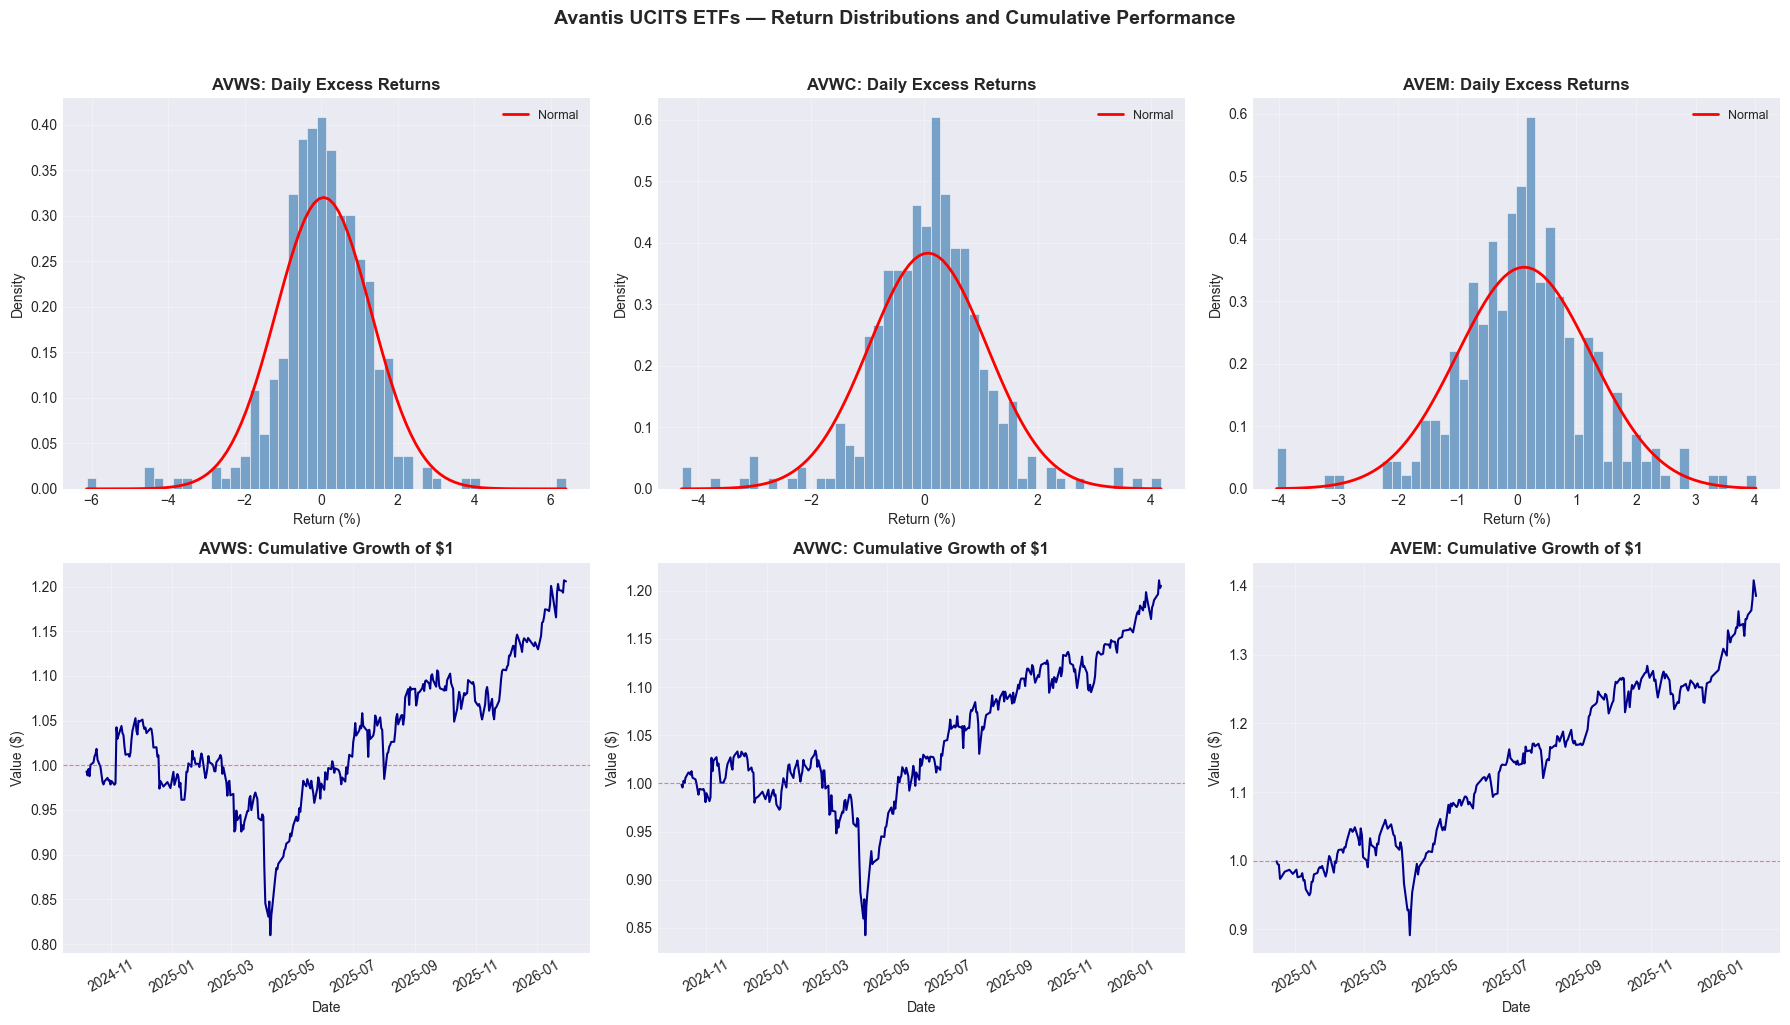


TOP ROW: Return distributions. Compare the histogram to the red normal curve.
Fat tails (excess kurtosis) are visible — returns have more extreme observations 
than a normal distribution would predict. This motivates robust standard errors.

BOTTOM ROW: Cumulative returns since inception. Remember: this is a very short 
period (~17 months). Short-term performance is dominated by market movements and 
luck, not factor premia (which require 10-20 year horizons per Wei Dai's research).



In [19]:
# ============================================================================
# Descriptive Statistics and Return Distributions
# ============================================================================

print("="*70)
print("DESCRIPTIVE STATISTICS — DAILY EXCESS RETURNS (% per day)")
print("="*70)

desc_stats = []
for ticker, name in etf_tickers.items():
    r = etf_dataframes[ticker]['Excess_Return']
    jb_stat, jb_p, skew_val, kurt_val = jarque_bera(r)
    
    # Ljung-Box test for autocorrelation (lag 5)
    lb_result = acorr_ljungbox(r, lags=[5], return_df=True)
    lb_p = lb_result['lb_pvalue'].values[0]
    
    # Ljung-Box on squared returns (volatility clustering)
    lb_sq = acorr_ljungbox(r**2, lags=[5], return_df=True)
    lb_sq_p = lb_sq['lb_pvalue'].values[0]
    
    desc_stats.append({
        'ETF': ticker.replace('.DE', ''),
        'N': len(r),
        'Mean (%)': f"{r.mean():.4f}",
        'Std (%)': f"{r.std():.4f}",
        'Skewness': f"{skew_val:.3f}",
        'Kurtosis': f"{kurt_val:.3f}",
        'JB p-value': f"{jb_p:.4f}",
        'LB(5) p': f"{lb_p:.4f}",
        'LB²(5) p': f"{lb_sq_p:.4f}",
        'Min (%)': f"{r.min():.2f}",
        'Max (%)': f"{r.max():.2f}",
    })

desc_df = pd.DataFrame(desc_stats).set_index('ETF')
print(desc_df.to_string())

print("""
INTERPRETATION:
━━━━━━━━━━━━━━
• JB p-value < 0.05 → Returns are NOT normally distributed (expected for 
  financial data, as discussed in Notebook 2, Section 1)
  
• LB(5) p-value: Tests for autocorrelation in returns. 
  p < 0.05 → significant autocorrelation detected

• LB²(5) p-value: Tests for autocorrelation in SQUARED returns 
  (volatility clustering). p < 0.05 → ARCH effects present
  (as expected from Notebook 2, Section 4)

→ These diagnostics confirm that Newey-West standard errors are appropriate
  for our factor regressions (they account for both autocorrelation and 
  heteroskedasticity).
""")

# ============================================================================
# Visualisation: Return Distributions and Cumulative Returns
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (ticker, name) in enumerate(etf_tickers.items()):
    r = etf_dataframes[ticker]['Excess_Return']
    short_name = ticker.replace('.DE', '')
    
    # Top row: Return histograms with normal overlay
    ax = axes[0, i]
    ax.hist(r, bins=50, density=True, alpha=0.7, color='steelblue', 
            edgecolor='white', linewidth=0.5)
    x = np.linspace(r.min(), r.max(), 100)
    ax.plot(x, stats.norm.pdf(x, r.mean(), r.std()), 'r-', linewidth=2,
            label='Normal')
    ax.set_title(f'{short_name}: Daily Excess Returns', fontweight='bold')
    ax.set_xlabel('Return (%)')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Bottom row: Cumulative returns
    ax = axes[1, i]
    cum_ret = (1 + r / 100).cumprod()
    ax.plot(cum_ret.index, cum_ret, color='darkblue', linewidth=1.5)
    ax.axhline(1, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title(f'{short_name}: Cumulative Growth of $1', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value ($)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Avantis UCITS ETFs — Return Distributions and Cumulative Performance',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('avantis_descriptive.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
TOP ROW: Return distributions. Compare the histogram to the red normal curve.
Fat tails (excess kurtosis) are visible — returns have more extreme observations 
than a normal distribution would predict. This motivates robust standard errors.

BOTTOM ROW: Cumulative returns since inception. Remember: this is a very short 
period (~17 months). Short-term performance is dominated by market movements and 
luck, not factor premia (which require 10-20 year horizons per Wei Dai's research).
""")

---

## Section 4: Factor Regression Analysis

This is the core analytical section. We regress each ETF's **monthly** excess returns on the Fama-French factor model:

$$R_i(t) - R_f(t) = \alpha_i + \beta_{MKT} (R_m - R_f)(t) + \beta_{SMB} \cdot SMB(t) + \beta_{HML} \cdot HML(t) + \beta_{RMW} \cdot RMW(t) + \beta_{CMA} \cdot CMA(t) + \beta_{UMD} \cdot UMD(t) + \epsilon_i(t)$$

We use **Newey-West standard errors** with automatic lag selection, as justified in [Notebook 1, Section 7](01_Statistical_Foundations.ipynb). This accounts for both autocorrelation and heteroskedasticity in the residuals.

For each ETF, we run three model specifications to see how the factor set changes the picture:
1. **FF3** (MKT, SMB, HML) — the baseline from [Notebook 3](03_Fama_French_3Factor.ipynb)
2. **FF5+Mom** (MKT, SMB, HML, RMW, CMA, UMD) — the full academic 6-factor model
3. **RR-style 5-factor** (MKT, SMB, HML, RMW, WML — **no CMA**) — the specification commonly used on the Rational Reminder forum

**Why include the model without CMA?** CMA (Conservative Minus Aggressive) is highly correlated with HML in short samples. Including both can inflate standard errors and destabilise individual coefficients (e.g. flipping the sign of RMW). Dropping CMA follows the Dimensional/Avantis "expected returns" framework, which emphasises value (HML), profitability (RMW), and momentum (WML) as the key return drivers, viewing investment (CMA) as largely redundant with value.

**Factor universe matching:**
- **AVWS** and **AVWC** are regressed against **Developed Markets monthly factors** — a proper match. Monthly frequency eliminates the non-synchronous trading bias discussed in Section 2.
- **AVEM** is regressed against **Emerging Markets monthly FF5** (5 factors, no momentum) — the only correct specification for an EM fund.

In [20]:
# ============================================================================
# Factor Regression Helper Function
# ============================================================================

def run_factor_regression(etf_data, factor_cols, ticker_name, nw_lags=None):
    """
    Run OLS regression with Newey-West standard errors.
    
    Parameters
    ----------
    etf_data : DataFrame with 'Excess_Return' and factor columns
    factor_cols : list of factor column names
    ticker_name : string for display
    nw_lags : int or None (auto = int(4*(T/100)^(2/9)))
    
    Returns
    -------
    statsmodels RegressionResults
    """
    y = etf_data['Excess_Return'].values
    X = sm.add_constant(etf_data[factor_cols].values)
    
    # Automatic Newey-West lag selection (Andrews, 1991 rule of thumb)
    T = len(y)
    if nw_lags is None:
        nw_lags = int(np.ceil(4 * (T / 100) ** (2/9)))
    
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': nw_lags})
    
    return results, nw_lags

def print_regression_results(results, factor_cols, ticker_name, nw_lags, 
                              freq='daily'):
    """Pretty-print regression results.
    
    Parameters
    ----------
    freq : 'daily' or 'monthly' — controls how alpha is annualised
    """
    param_names = ['Alpha (α)'] + factor_cols
    ann_mult = 252 if freq == 'daily' else 12
    freq_label = 'daily' if freq == 'daily' else 'monthly'
    
    print(f"\n{'='*65}")
    print(f"  {ticker_name}")
    print(f"  Newey-West lags: {nw_lags} | N = {int(results.nobs)} | R² = {results.rsquared:.4f}")
    print(f"{'='*65}")
    print(f"{'Factor':<14} {'Coeff':>10} {'Std Err':>10} {'t-stat':>10} {'p-value':>10} {'Sig':>5}")
    print(f"{'-'*65}")
    
    for i, name in enumerate(param_names):
        coef = results.params[i]
        se = results.bse[i]
        t = results.tvalues[i]
        p = results.pvalues[i]
        sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
        print(f"{name:<14} {coef:>10.4f} {se:>10.4f} {t:>10.3f} {p:>10.4f} {sig:>5}")
    
    # Annualise alpha
    alpha = results.params[0]
    alpha_annual = alpha * ann_mult
    print(f"\n  Annualised alpha ≈ {alpha_annual:.2f}% (= {alpha:.4f}% × {ann_mult})")
    print(f"  Residual std ({freq_label}) = {np.sqrt(results.mse_resid):.4f}%")

print("Regression helper functions defined.")

Regression helper functions defined.


In [29]:
# ============================================================================
# Run FF3, FF5+Momentum, and RR-style 5-Factor Regressions — ALL Monthly
# ============================================================================

ff3_cols  = ['Mkt_RF', 'SMB', 'HML']
ff5_cols  = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']
ff6_cols  = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
rr5f_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'UMD']  # "Rational Reminder" style: no CMA

# Define which full model each ETF uses
etf_model_spec = {
    'AVWS.DE': {'cols_full': ff6_cols, 'label': 'DM Monthly FF5+Mom', 'nw': None},
    'AVWC.DE': {'cols_full': ff6_cols, 'label': 'DM Monthly FF5+Mom', 'nw': None},
    'AVEM.DE': {'cols_full': ff5_cols, 'label': 'EM Monthly FF5',     'nw': 1},
}

results_3f = {}
results_6f = {}    # full model (FF6 for DM, FF5 for EM)
results_rr5f = {}  # RR-style 5-factor (no CMA) for DM ETFs

# ---- FF3 for all ETFs (monthly) ----
print("█"*70)
print("  FAMA-FRENCH 3-FACTOR REGRESSIONS — ALL MONTHLY")
print("█"*70)

for ticker, name in etf_tickers.items():
    spec = etf_model_spec[ticker]
    df = etf_monthly_dfs[ticker]
    nw = spec['nw']
    res, lags = run_factor_regression(df, ff3_cols, f"{ticker} — {name}", nw_lags=nw)
    results_3f[ticker] = res
    print_regression_results(res, ff3_cols,
                             f"{ticker} — {name} [3-Factor, {spec['label']}]",
                             lags, freq='monthly')

# ---- Full model for all ETFs (monthly) ----
print("\n\n" + "█"*70)
print("  FULL FACTOR MODEL — ALL MONTHLY")
print("  AVWS/AVWC: FF5+Mom (6 factors)  |  AVEM: FF5 (5 factors)")
print("█"*70)

for ticker, name in etf_tickers.items():
    spec = etf_model_spec[ticker]
    df = etf_monthly_dfs[ticker]
    nw = spec['nw']
    full_cols = spec['cols_full']
    res, lags = run_factor_regression(df, full_cols, f"{ticker} — {name}", nw_lags=nw)
    results_6f[ticker] = res
    print_regression_results(res, full_cols,
                             f"{ticker} — {name} [{spec['label']}]",
                             lags, freq='monthly')

# ---- RR-style 5-factor (MKT, SMB, HML, RMW, WML — no CMA) for DM ETFs ----
print("\n\n" + "█"*70)
print("  RATIONAL REMINDER-STYLE 5-FACTOR (MKT, SMB, HML, RMW, WML — no CMA)")
print("  AVWS and AVWC only (DM monthly)")
print("█"*70)
print("\n  This model drops CMA to match the specification commonly used on the")
print("  Rational Reminder forum. CMA is highly correlated with HML in short")
print("  samples, and dropping it can stabilise the remaining coefficients.")

for ticker, name in etf_tickers.items():
    if ticker == 'AVEM.DE':
        continue  # EM already uses FF5 (no UMD, no CMA)
    df = etf_monthly_dfs[ticker]
    res, lags = run_factor_regression(df, rr5f_cols, f"{ticker} — {name}")
    results_rr5f[ticker] = res
    print_regression_results(res, rr5f_cols,
                             f"{ticker} — {name} [RR 5-Factor, DM Monthly]",
                             lags, freq='monthly')

# Store references for backward compatibility
avem_em_3f = results_3f['AVEM.DE']
avem_em_6f = results_6f['AVEM.DE']
avem_em_lags_3f = 1
avem_em_lags_6f = 1

██████████████████████████████████████████████████████████████████████
  FAMA-FRENCH 3-FACTOR REGRESSIONS — ALL MONTHLY
██████████████████████████████████████████████████████████████████████

  AVWS.DE — Avantis Global Small Cap Value [3-Factor, DM Monthly FF5+Mom]
  Newey-West lags: 3 | N = 16 | R² = 0.8764
Factor              Coeff    Std Err     t-stat    p-value   Sig
-----------------------------------------------------------------
Alpha (α)         -0.8956     0.2945     -3.041     0.0024   ***
Mkt_RF             1.3930     0.0790     17.641     0.0000   ***
SMB                0.4283     0.2835      1.511     0.1308      
HML                0.6470     0.1296      4.992     0.0000   ***

  Annualised alpha ≈ -10.75% (= -0.8956% × 12)
  Residual std (monthly) = 1.6979%

  AVWC.DE — Avantis Global Equity [3-Factor, DM Monthly FF5+Mom]
  Newey-West lags: 3 | N = 16 | R² = 0.9329
Factor              Coeff    Std Err     t-stat    p-value   Sig
-----------------------------------------

RESIDUAL DIAGNOSTICS (FULL FACTOR MODEL — MONTHLY)
All regressions use monthly returns. AVWS/AVWC: DM FF5+Mom; AVEM: EM FF5.



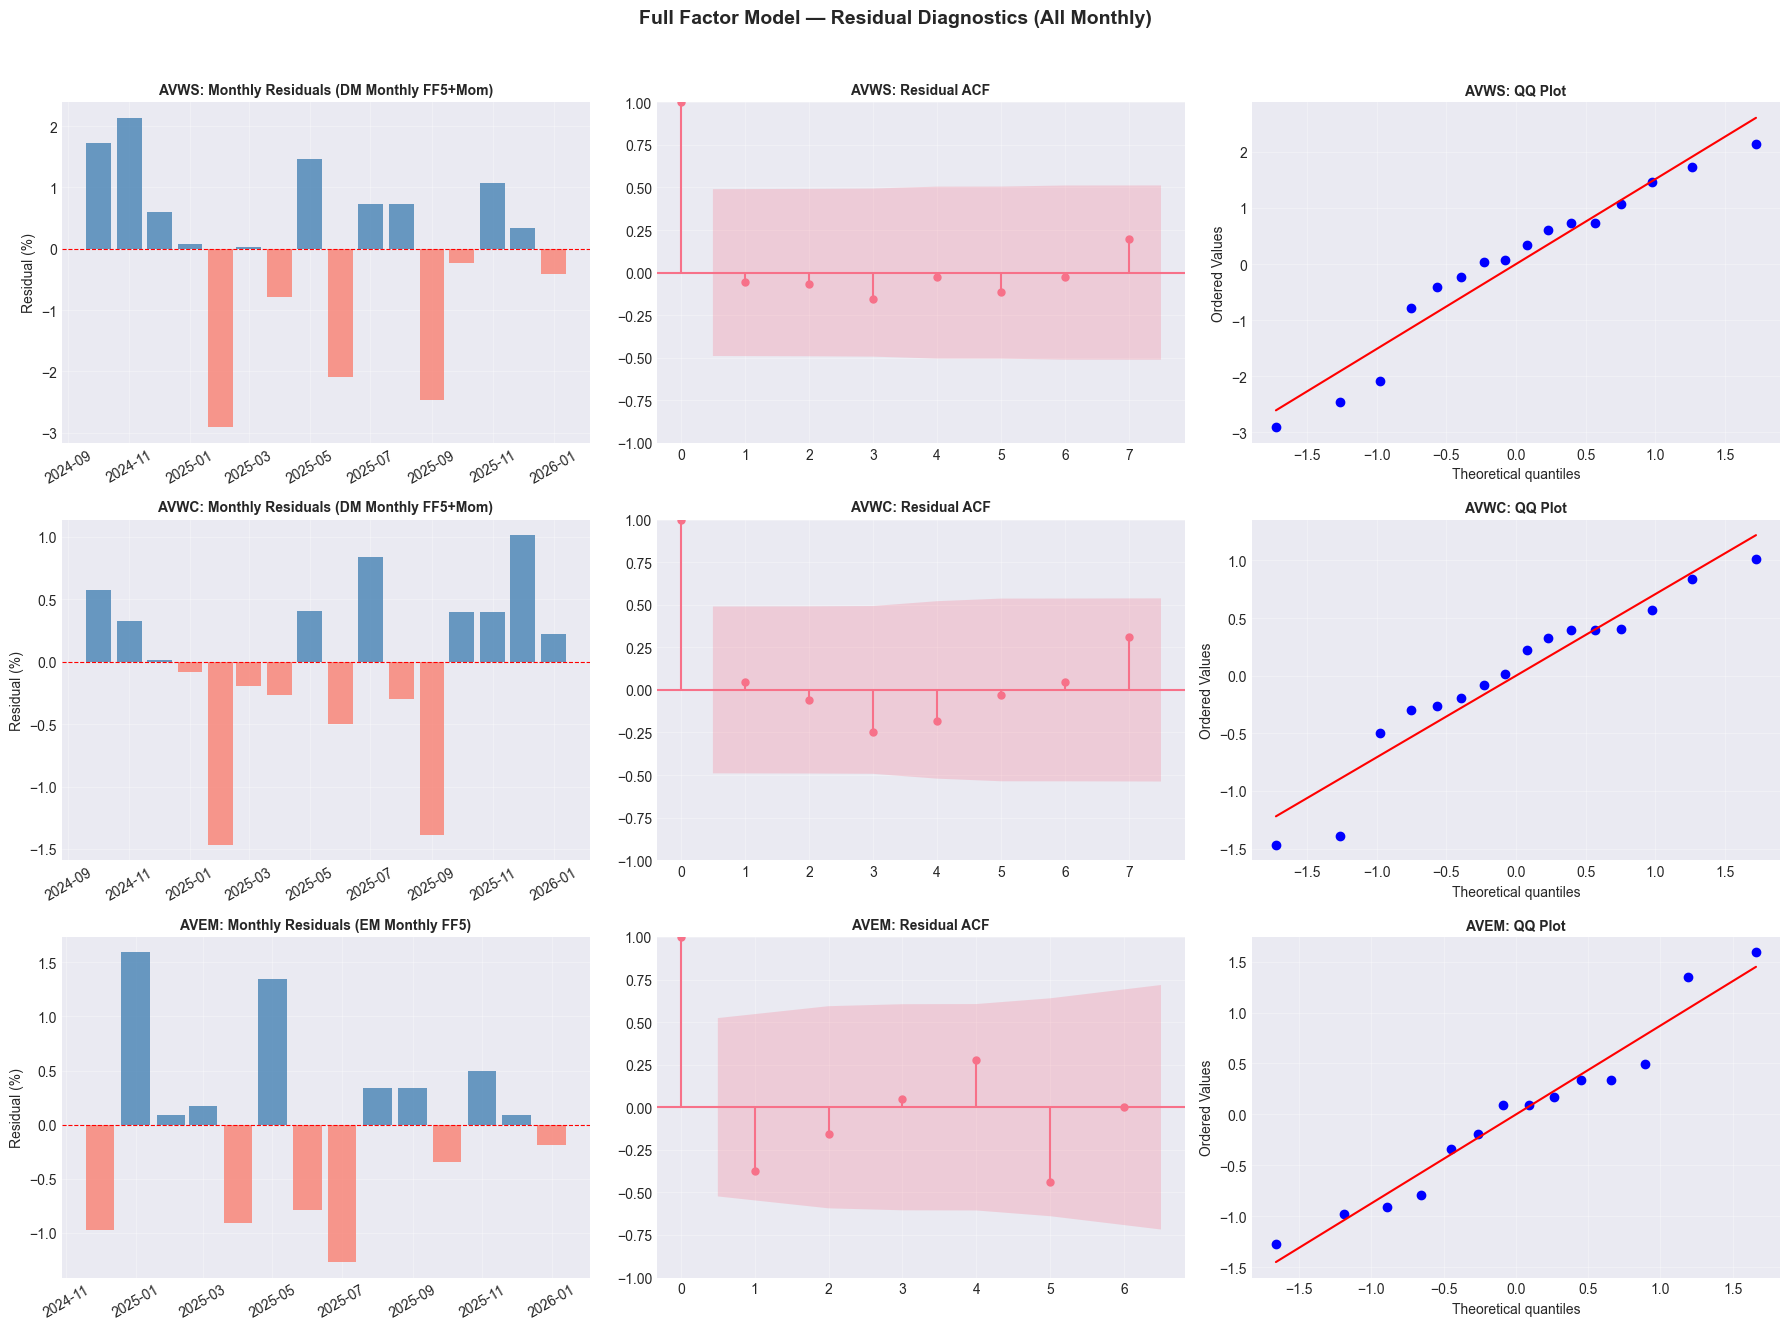


FORMAL DIAGNOSTIC TESTS (monthly residuals):
ETF           N   Ljung-Box(4)   p-value    JB stat      JB p    Skew    Kurt
--------------------------------------------------------------------------------
AVWS         16           0.69    0.9528       1.22    0.5427   -0.64   -0.45
AVWC         16           2.25    0.6895       1.78    0.4101   -0.82    0.12
AVEM         14           4.68    0.3216       0.43    0.8069    0.34   -0.53

Interpretation:
  • Ljung-Box tests for residual autocorrelation (H₀: no serial correlation)
  • Jarque-Bera tests for normality (H₀: residuals are normally distributed)
  • With ~15 monthly observations, these tests have low power; interpret cautiously
  • Newey-West SEs remain valid regardless of the JB test outcome


In [22]:
# ============================================================================
# Residual Diagnostics — Validating Our Regression Assumptions (All Monthly)
# ============================================================================
# Following the diagnostic approach from Notebook 3, Section 5

print("="*70)
print("RESIDUAL DIAGNOSTICS (FULL FACTOR MODEL — MONTHLY)")
print("="*70)
print("All regressions use monthly returns. AVWS/AVWC: DM FF5+Mom; AVEM: EM FF5.\n")

fig, axes = plt.subplots(3, 3, figsize=(18, 13))

for i, (ticker, name) in enumerate(etf_tickers.items()):
    res = results_6f[ticker]
    resid = res.resid
    short = ticker.replace('.DE', '')
    dates = etf_monthly_dfs[ticker].index
    spec = etf_model_spec[ticker]
    max_acf_lags = min(8, len(resid) // 2 - 1)  # fewer lags for short monthly samples
    
    # Column 1: Residual time series (bar chart for monthly)
    ax = axes[i, 0]
    colours = ['steelblue' if r >= 0 else 'salmon' for r in resid]
    ax.bar(dates, resid, width=25, color=colours, alpha=0.8, edgecolor='none')
    ax.axhline(0, color='red', linestyle='--', linewidth=0.8)
    ax.set_title(f'{short}: Monthly Residuals ({spec["label"]})', fontweight='bold', fontsize=10)
    ax.set_ylabel('Residual (%)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)
    
    # Column 2: Residual ACF
    ax = axes[i, 1]
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(resid, ax=ax, lags=max_acf_lags, alpha=0.05)
    ax.set_title(f'{short}: Residual ACF', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Column 3: QQ Plot
    ax = axes[i, 2]
    stats.probplot(resid, dist='norm', plot=ax)
    ax.set_title(f'{short}: QQ Plot', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Full Factor Model — Residual Diagnostics (All Monthly)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('avantis_diagnostics.png', dpi=100, bbox_inches='tight')
plt.show()

# Formal tests for all ETFs
print("\nFORMAL DIAGNOSTIC TESTS (monthly residuals):")
print(f"{'ETF':<10} {'N':>4} {'Ljung-Box(4)':>14} {'p-value':>9} {'JB stat':>10} {'JB p':>9} {'Skew':>7} {'Kurt':>7}")
print("-"*80)

for ticker, name in etf_tickers.items():
    res = results_6f[ticker]
    resid = res.resid
    short = ticker.replace('.DE', '')
    T = len(resid)
    max_lb = min(4, T // 3)
    
    # Ljung-Box
    lb_result = sm.stats.acorr_ljungbox(resid, lags=[max_lb], return_df=True)
    lb, lb_p = lb_result.iloc[0]['lb_stat'], lb_result.iloc[0]['lb_pvalue']
    
    # Jarque-Bera
    jb_stat, jb_p = stats.jarque_bera(resid)
    skew_val = stats.skew(resid)
    kurt_val = stats.kurtosis(resid)
    
    print(f"{short:<10} {T:>4} {lb:>14.2f} {lb_p:>9.4f} {jb_stat:>10.2f} {jb_p:>9.4f} {skew_val:>7.2f} {kurt_val:>7.2f}")

print("\nInterpretation:")
print("  • Ljung-Box tests for residual autocorrelation (H₀: no serial correlation)")
print("  • Jarque-Bera tests for normality (H₀: residuals are normally distributed)")
print("  • With ~15 monthly observations, these tests have low power; interpret cautiously")
print("  • Newey-West SEs remain valid regardless of the JB test outcome")

---

## Section 5: Comparative Factor Profiles

Now we compare the factor exposures across all three ETFs side by side. This reveals how each fund implements Avantis' "scientific approach" differently depending on its investment universe.

We show both our **full model** (FF5+Mom for AVWS/AVWC, FF5 for AVEM) and the **RR-style 5-factor** (no CMA) results for the DM ETFs.

**An important caveat on comparability:** AVWS and AVWC betas come from monthly regressions against **Developed Markets** factors, while AVEM betas come from monthly regressions against **Emerging Markets** factors. These are *different factor universes*, so the betas are not directly comparable. For AVEM, UMD is set to zero in the chart since momentum is not included in the EM model.

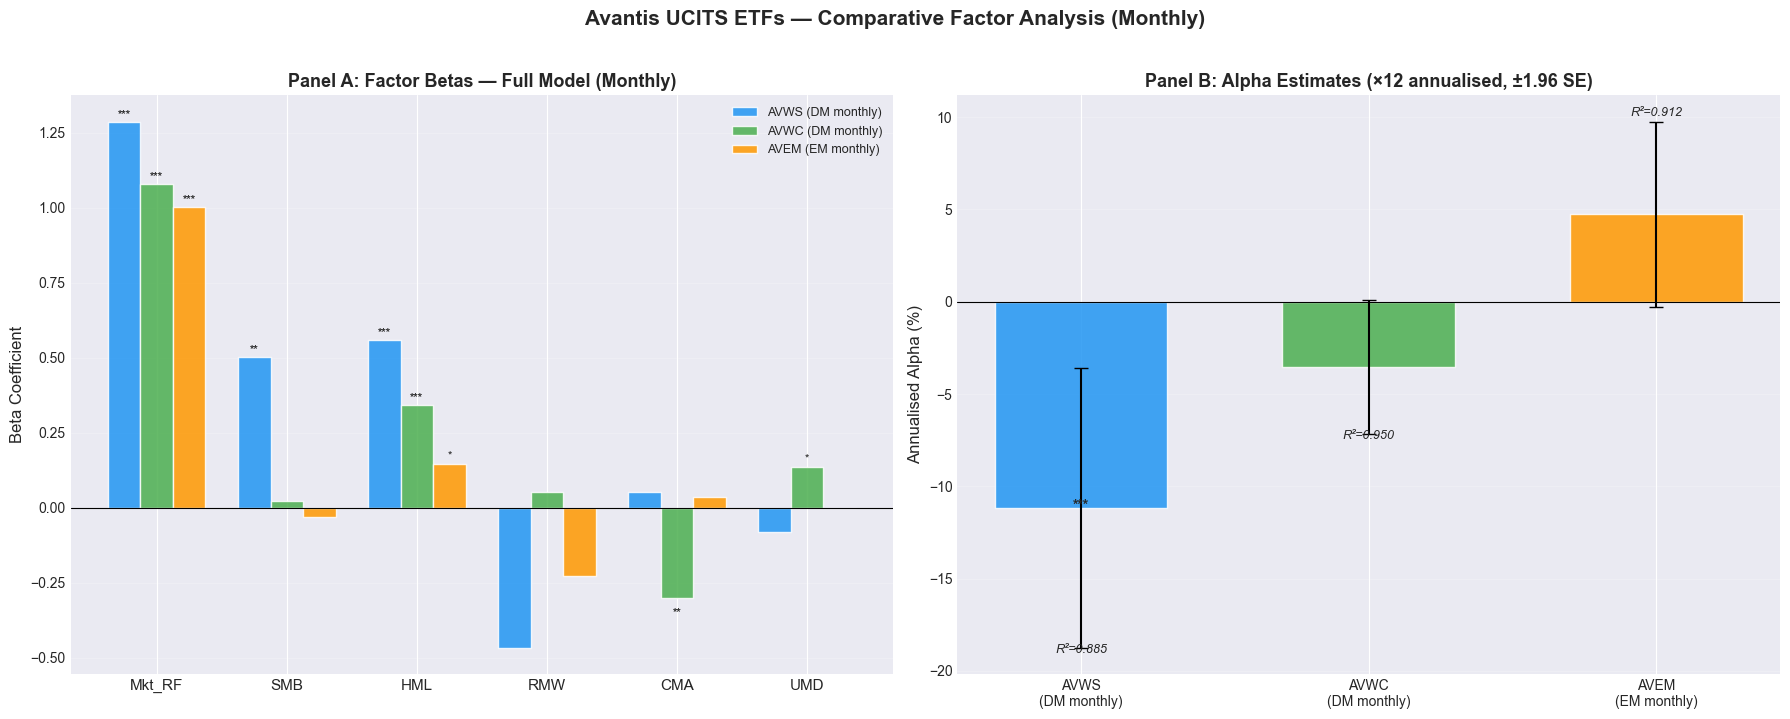


FULL MODEL SUMMARY (FF5+Mom for AVWS/AVWC, FF5 for AVEM)
ETF      Model                 N      R²   α (ann)     MKT     SMB     HML     RMW     CMA     UMD
-----------------------------------------------------------------------------------------------
AVWS     DM Monthly FF5+Mom   16  0.8850   -11.15%  1.29***  0.50**  0.56***   -0.47    0.05   -0.08
AVWC     DM Monthly FF5+Mom   16  0.9501    -3.52%  1.08***    0.02  0.34***    0.05 -0.30**   0.14*
AVEM     EM Monthly FF5       14  0.9116     4.73%  1.00***   -0.03   0.15*   -0.23    0.04     n/a


RR-STYLE 5-FACTOR COMPARISON (MKT, SMB, HML, RMW, WML — no CMA)
Our monthly regressions vs. Rational Reminder forum values (Dec 2025)

                       MKT      SMB      HML      RMW      WML       R²    α (ann)
--------------------------------------------------------------------------------
AVWC     Ours      1.07***  0.00    0.19** -0.09    0.11*   0.9409     -2.49%
         Forum       1.01    0.10    0.16    0.07    0.03     n/a 

In [30]:
# ============================================================================
# Comparative Factor Exposure Chart (All Monthly) + Forum Comparison
# ============================================================================

factor_names = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
all_tickers = list(etf_tickers.keys())
etf_short_names = [t.replace('.DE', '') for t in all_tickers]
colors = ['#2196F3', '#4CAF50', '#FF9800']  # Blue, Green, Orange

# Collect coefficients from the full model (FF6 for DM, FF5 for EM)
coef_matrix = np.zeros((len(all_tickers), len(factor_names)))
sig_matrix = np.ones((len(all_tickers), len(factor_names)))
se_matrix = np.zeros((len(all_tickers), len(factor_names)))

for i, ticker in enumerate(all_tickers):
    res = results_6f[ticker]
    spec = etf_model_spec[ticker]
    model_factors = spec['cols_full']
    for j, factor in enumerate(factor_names):
        if factor in model_factors:
            k = model_factors.index(factor) + 1
            coef_matrix[i, j] = res.params[k]
            sig_matrix[i, j] = res.pvalues[k]
            se_matrix[i, j] = res.bse[k]

# Plot: Side-by-side bar chart of factor loadings + alpha comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Panel A: Factor Betas (full model)
ax = axes[0]
x = np.arange(len(factor_names))
width = 0.25
for i, (etf_name, color) in enumerate(zip(etf_short_names, colors)):
    ticker = all_tickers[i]
    freq_label = 'DM monthly' if ticker != 'AVEM.DE' else 'EM monthly'
    bars = ax.bar(x + i * width - width, coef_matrix[i], width, 
                  label=f'{etf_name} ({freq_label})', color=color, alpha=0.85, 
                  edgecolor='white')
    for j, bar in enumerate(bars):
        ypos = bar.get_height() + 0.01 if bar.get_height() >= 0 else bar.get_height() - 0.03
        if sig_matrix[i, j] < 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, ypos, '***', 
                    ha='center', va='bottom' if bar.get_height() >= 0 else 'top',
                    fontsize=8, fontweight='bold')
        elif sig_matrix[i, j] < 0.05:
            ax.text(bar.get_x() + bar.get_width()/2, ypos, '**',
                    ha='center', va='bottom' if bar.get_height() >= 0 else 'top',
                    fontsize=8, fontweight='bold')
        elif sig_matrix[i, j] < 0.10:
            ax.text(bar.get_x() + bar.get_width()/2, ypos, '*',
                    ha='center', va='bottom' if bar.get_height() >= 0 else 'top',
                    fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(factor_names, fontsize=11)
ax.set_ylabel('Beta Coefficient', fontsize=12)
ax.set_title('Panel A: Factor Betas — Full Model (Monthly)', fontweight='bold', fontsize=13)
ax.axhline(0, color='black', linewidth=0.8)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.2, axis='y')

# Panel B: Alpha comparison
ax = axes[1]
alphas = []
alpha_ses = []
alpha_sigs = []
labels = []
r2_vals = []
bar_colours = []

for i, ticker in enumerate(all_tickers):
    res = results_6f[ticker]
    short = etf_short_names[i]
    spec = etf_model_spec[ticker]
    ann = 12
    a = res.params[0] * ann
    a_se = res.bse[0] * ann
    a_sig = res.pvalues[0]
    r2 = res.rsquared
    freq_label = 'DM monthly' if ticker != 'AVEM.DE' else 'EM monthly'
    label = f'{short}\n({freq_label})'
    alphas.append(a)
    alpha_ses.append(a_se)
    alpha_sigs.append(a_sig)
    labels.append(label)
    r2_vals.append(r2)
    bar_colours.append(colors[i])

x_alpha = np.arange(len(alphas))
bars = ax.bar(x_alpha, alphas, color=bar_colours, alpha=0.85, edgecolor='white', width=0.6)
ax.errorbar(x_alpha, alphas, yerr=[1.96*s for s in alpha_ses], 
            fmt='none', color='black', capsize=5, linewidth=1.5)

for j, bar in enumerate(bars):
    ypos = bar.get_height() + 1.96*alpha_ses[j] + 0.3 if bar.get_height() >= 0 \
           else bar.get_height() - 1.96*alpha_ses[j] - 0.3
    ax.text(bar.get_x() + bar.get_width()/2, ypos, f'R²={r2_vals[j]:.3f}',
            ha='center', fontsize=9, style='italic')
    sig_ypos = bar.get_height() + 0.1 if bar.get_height() >= 0 else bar.get_height() - 0.1
    if alpha_sigs[j] < 0.01:
        ax.text(bar.get_x() + bar.get_width()/2, sig_ypos, '***',
                ha='center', fontsize=10, fontweight='bold')
    elif alpha_sigs[j] < 0.05:
        ax.text(bar.get_x() + bar.get_width()/2, sig_ypos, '**',
                ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(x_alpha)
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel('Annualised Alpha (%)', fontsize=12)
ax.set_title('Panel B: Alpha Estimates (×12 annualised, ±1.96 SE)', fontweight='bold', fontsize=13)
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.2, axis='y')

plt.suptitle('Avantis UCITS ETFs — Comparative Factor Analysis (Monthly)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('avantis_factor_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

# ============================================================================
# Summary: Full model (FF6/FF5)
# ============================================================================
print("\n" + "="*95)
print("FULL MODEL SUMMARY (FF5+Mom for AVWS/AVWC, FF5 for AVEM)")
print("="*95)
print(f"{'ETF':<8} {'Model':<18} {'N':>4} {'R²':>7} {'α (ann)':>9} {'MKT':>7} {'SMB':>7} {'HML':>7} {'RMW':>7} {'CMA':>7} {'UMD':>7}")
print("-"*95)
for i, ticker in enumerate(all_tickers):
    res = results_6f[ticker]
    short = etf_short_names[i]
    spec = etf_model_spec[ticker]
    alpha_ann = res.params[0] * 12
    betas = []
    for factor in factor_names:
        if factor in spec['cols_full']:
            k = spec['cols_full'].index(factor) + 1
            coef = res.params[k]
            p = res.pvalues[k]
            sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
            betas.append(f'{coef:>5.2f}{sig}')
        else:
            betas.append(f'{"n/a":>7}')
    print(f"{short:<8} {spec['label']:<18} {int(res.nobs):>4} {res.rsquared:>7.4f} {alpha_ann:>8.2f}% " 
          + ' '.join(f'{b:>7}' for b in betas))

# ============================================================================
# Comparison: RR-style 5-Factor (no CMA) vs. Rational Reminder Forum
# ============================================================================
print("\n\n" + "="*95)
print("RR-STYLE 5-FACTOR COMPARISON (MKT, SMB, HML, RMW, WML — no CMA)")
print("Our monthly regressions vs. Rational Reminder forum values (Dec 2025)")
print("="*95)

# Forum values from the screenshot (AYB's post, Dec 2025)
forum_values = {
    'AVWC': {'MKT': 1.01, 'SMB': 0.10, 'HML': 0.16, 'RMW': 0.07, 'WML': 0.03},
    'AVWS': {'MKT': 1.09, 'SMB': 0.81, 'HML': 0.51, 'RMW': 0.25, 'WML': 0.00},
}

rr5_display = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'UMD']
rr5_forum_keys = ['MKT', 'SMB', 'HML', 'RMW', 'WML']

print(f"\n{'':>8} {'':>8} {'MKT':>8} {'SMB':>8} {'HML':>8} {'RMW':>8} {'WML':>8} {'R²':>8} {'α (ann)':>10}")
print("-"*80)

for ticker in ['AVWC.DE', 'AVWS.DE']:
    short = ticker.replace('.DE', '')
    res = results_rr5f[ticker]
    
    # Our RR-style results
    our_betas = {f: res.params[rr5_display.index(f) + 1] for f in rr5_display}
    alpha_ann = res.params[0] * 12
    
    print(f"{short:<8} {'Ours':<8}", end='')
    for f, fk in zip(rr5_display, rr5_forum_keys):
        p = res.pvalues[rr5_display.index(f) + 1]
        sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
        print(f"{our_betas[f]:>6.2f}{sig:<2s}", end='')
    print(f" {res.rsquared:>7.4f}  {alpha_ann:>8.2f}%")
    
    # Forum values
    fv = forum_values[short]
    print(f"{'':>8} {'Forum':<8}", end='')
    for fk in rr5_forum_keys:
        print(f"{fv[fk]:>8.2f}", end='')
    print(f" {'n/a':>7}  {'n/a':>9}")
    
    # Difference
    print(f"{'':>8} {'Δ':<8}", end='')
    for f, fk in zip(rr5_display, rr5_forum_keys):
        diff = our_betas[f] - fv[fk]
        print(f"{diff:>+8.2f}", end='')
    print()
    print()

print("Notes:")
print("  • 'Forum' values from Rational Reminder UCITS discussion thread (AYB, Dec 2025)")
print("  • Remaining differences likely due to: sample end date (forum ~Nov 2025 vs ours")
print("    ~Jan 2026), possible use of US-listed AVWC/AVWS, or global vs DM factors")
print("  • Our R² and alpha are shown for reference; forum did not report these")

---

## Section 6: Portfolio Construction — 50% AVWS / 40% AVWC / 10% AVEM

Now we construct a combined portfolio and analyse its characteristics. This allocation represents a **globally diversified, factor-tilted equity portfolio**:

- **50% AVWS** — A heavy tilt toward global small-cap value (the strongest documented factor premia)
- **40% AVWC** — Broad global equity with gentle factor tilts (core holding, provides diversification)
- **10% AVEM** — Emerging markets exposure (geographic diversification, potentially different factor dynamics)

This type of allocation aligns with the Rational Reminder framework: a factor-tilted core supplemented by a meaningful small-cap value overweight, with some EM diversification.

### Why These Weights?

The 50/40/10 split reflects several considerations:
1. **Academic evidence is strongest for small-cap value** — Wei Dai's research shows small-cap value has the highest expected premium, so a large AVWS allocation targets this
2. **Diversification requires breadth** — AVWC provides broad market exposure and reduces tracking error vs. a pure small-cap value bet (Bessembinder's skewness argument)
3. **EM adds geographic diversity** — Factor premia have been documented globally (Asness, Moskowitz & Pedersen, 2013), but EM markets may behave differently

> **Important:** We can only construct this portfolio from the date when all three ETFs have available data (the latest inception date). Since AVEM launched in December 2024, our combined portfolio history is limited to approximately 15 months. The portfolio-level factor regressions use **Developed Markets monthly factors**, which is appropriate given the 90% developed-market weight (50% AVWS + 40% AVWC).

In [24]:
# ============================================================================
# 6.1 — Build the Portfolio (daily for charts, monthly for regressions)
# ============================================================================

weights = {'AVWS.DE': 0.50, 'AVWC.DE': 0.40, 'AVEM.DE': 0.10}

# ---- A. Daily portfolio (for cumulative return chart & drawdown) ----
common_dates = etf_dataframes['AVWS.DE'].index
for ticker in ['AVWC.DE', 'AVEM.DE']:
    common_dates = common_dates.intersection(etf_dataframes[ticker].index)

print(f"Common daily dates across all three ETFs: {len(common_dates)}")
print(f"Date range: {common_dates[0].date()} to {common_dates[-1].date()}")
print()

port_data = pd.DataFrame(index=common_dates)
for ticker in etf_tickers:
    short = ticker.replace('.DE', '')
    port_data[f'{short}_excess'] = etf_dataframes[ticker].loc[common_dates, 'Excess_Return']
    port_data[f'{short}_ret'] = etf_dataframes[ticker].loc[common_dates, 'ETF_Return']

# Add DM daily factor columns (for cumulative chart reference)
factor_cols_all = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD', 'RF']
for col in factor_cols_all:
    port_data[col] = etf_dataframes['AVWS.DE'].loc[common_dates, col]

# Compute daily portfolio returns
port_data['Port_ret'] = (weights['AVWS.DE'] * port_data['AVWS_ret']
                       + weights['AVWC.DE'] * port_data['AVWC_ret']
                       + weights['AVEM.DE'] * port_data['AVEM_ret'])

port_data['Port_excess'] = (weights['AVWS.DE'] * port_data['AVWS_excess']
                          + weights['AVWC.DE'] * port_data['AVWC_excess']
                          + weights['AVEM.DE'] * port_data['AVEM_excess'])

# ---- B. Monthly portfolio (for regressions) ---- 
# Use DM monthly factors since portfolio is 90% DM
common_months = etf_monthly_dfs['AVWS.DE'].index
for ticker in ['AVWC.DE', 'AVEM.DE']:
    common_months = common_months.intersection(etf_monthly_dfs[ticker].index)

print(f"Common monthly dates across all three ETFs: {len(common_months)}")
print(f"Date range: {common_months[0].date()} to {common_months[-1].date()}")
print()

port_monthly = pd.DataFrame(index=common_months)
for ticker in etf_tickers:
    short = ticker.replace('.DE', '')
    port_monthly[f'{short}_excess'] = etf_monthly_dfs[ticker].loc[common_months, 'Excess_Return']
    port_monthly[f'{short}_ret'] = etf_monthly_dfs[ticker].loc[common_months, 'ETF_Return']

# Add DM monthly factors for portfolio regression
for col in ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD', 'RF']:
    port_monthly[col] = dm_factors_monthly.loc[common_months, col] if col != 'RF' \
        else dm_factors_monthly.loc[common_months, 'RF']

port_monthly['Port_ret'] = (weights['AVWS.DE'] * port_monthly['AVWS_ret']
                          + weights['AVWC.DE'] * port_monthly['AVWC_ret']
                          + weights['AVEM.DE'] * port_monthly['AVEM_ret'])

port_monthly['Port_excess'] = (weights['AVWS.DE'] * port_monthly['AVWS_excess']
                             + weights['AVWC.DE'] * port_monthly['AVWC_excess']
                             + weights['AVEM.DE'] * port_monthly['AVEM_excess'])

# ---- Summary Statistics (daily) ----
print("=" * 65)
print("Portfolio Summary Statistics (daily returns, USD-converted, % units)")
print("=" * 65)

port_ret = port_data['Port_ret']
ann_factor = 252

summary = {
    'Mean daily return (%)':           port_ret.mean(),
    'Std. dev. daily (%)':             port_ret.std(),
    'Annualised return (%)':           port_ret.mean() * ann_factor,
    'Annualised volatility (%)':       port_ret.std() * np.sqrt(ann_factor),
    'Sharpe ratio (annualised)':       port_ret.mean() / port_ret.std() * np.sqrt(ann_factor),
    'Skewness':                        stats.skew(port_ret),
    'Excess kurtosis':                 stats.kurtosis(port_ret),
    'Max daily loss (%)':              port_ret.min(),
    'Max daily gain (%)':              port_ret.max(),
}

for k, v in summary.items():
    print(f"  {k:<32s} {v:>10.4f}")

# Monthly summary
print(f"\n  Monthly portfolio obs (regression): {len(port_monthly)}")
print(f"  Mean monthly excess return:  {port_monthly['Port_excess'].mean():.2f}%")
print(f"  Ann. excess return (×12):    {port_monthly['Port_excess'].mean()*12:.2f}%")

Common daily dates across all three ETFs: 282
Date range: 2024-12-16 to 2026-01-30

Common monthly dates across all three ETFs: 14
Date range: 2024-12-01 to 2026-01-01

Portfolio Summary Statistics (daily returns, USD-converted, % units)
  Mean daily return (%)                0.0890
  Std. dev. daily (%)                  1.1183
  Annualised return (%)               22.4337
  Annualised volatility (%)           17.7523
  Sharpe ratio (annualised)            1.2637
  Skewness                            -0.6989
  Excess kurtosis                      3.2502
  Max daily loss (%)                  -4.9834
  Max daily gain (%)                   3.8401

  Monthly portfolio obs (regression): 14
  Mean monthly excess return:  1.25%
  Ann. excess return (×12):    15.00%


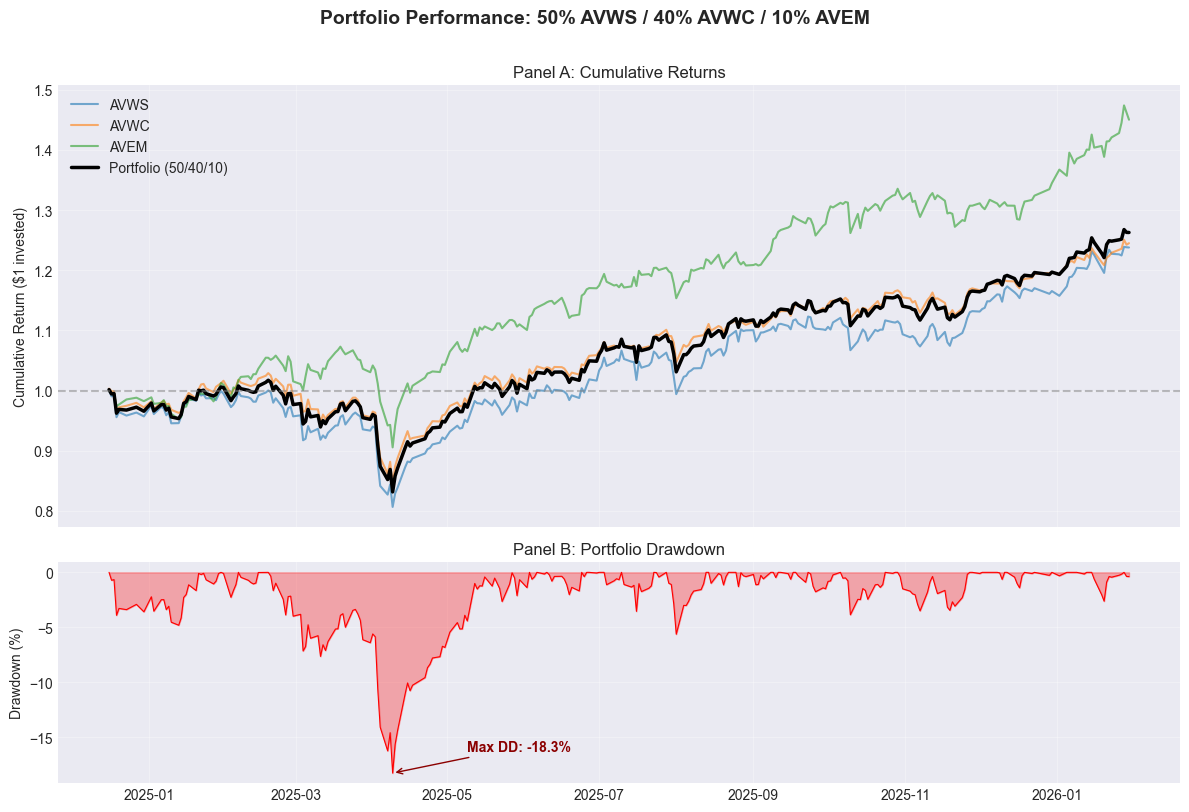


  Maximum drawdown: -18.25% on 2025-04-09
  Days from peak to trough: 50


In [25]:
# ============================================================================
# 6.2 — Cumulative Returns and Drawdown Analysis
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1]})

# Panel A: Cumulative returns  (returns are in % units, so divide by 100)
cum_port = (1 + port_data['Port_ret'] / 100).cumprod()
for short_name, colour in [('AVWS', '#1f77b4'), ('AVWC', '#ff7f0e'), ('AVEM', '#2ca02c')]:
    cum_etf = (1 + port_data[f'{short_name}_ret'] / 100).cumprod()
    axes[0].plot(cum_etf.index, cum_etf.values, label=short_name, alpha=0.6, color=colour)

axes[0].plot(cum_port.index, cum_port.values, label='Portfolio (50/40/10)',
             color='black', linewidth=2.5)
axes[0].set_ylabel('Cumulative Return ($1 invested)')
axes[0].legend(loc='upper left')
axes[0].set_title('Panel A: Cumulative Returns')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(1, color='grey', linestyle='--', alpha=0.5)

# Panel B: Portfolio drawdown
cum_max = cum_port.cummax()
drawdown = (cum_port - cum_max) / cum_max * 100
axes[1].fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
axes[1].plot(drawdown.index, drawdown.values, color='red', linewidth=0.8)
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_title('Panel B: Portfolio Drawdown')
axes[1].grid(True, alpha=0.3)

# Annotate maximum drawdown
max_dd = drawdown.min()
max_dd_date = drawdown.idxmin()
axes[1].annotate(f'Max DD: {max_dd:.1f}%',
                 xy=(max_dd_date, max_dd),
                 xytext=(max_dd_date + pd.Timedelta(days=30), max_dd + 2),
                 arrowprops=dict(arrowstyle='->', color='darkred'),
                 fontsize=10, color='darkred', fontweight='bold')

fig.suptitle('Portfolio Performance: 50% AVWS / 40% AVWC / 10% AVEM',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f"\n  Maximum drawdown: {max_dd:.2f}% on {max_dd_date.date()}")
print(f"  Days from peak to trough: "
      f"{(max_dd_date - cum_port[:max_dd_date].idxmax()).days}")

---

## Section 7: Portfolio Factor Analysis

Having analysed each ETF individually, we now run the same regressions on the **combined portfolio** using **monthly returns** and **Developed Markets monthly factors** (appropriate given the 90% DM weight). This serves two purposes:

1. **Verification** — Portfolio-level betas should approximately equal the weighted average of individual ETF betas (a direct consequence of the linearity of OLS). Note: this holds exactly only when all individual regressions use the same factors and sample. Since AVEM uses EM factors while the portfolio uses DM factors, there will be small differences.
2. **Holistic view** — The portfolio alpha, $R^2$, and residual diagnostics tell us about the *overall* factor profile of our allocation.

### The Linearity Property

Because OLS is a linear operator, if the portfolio return is:
$$
R_p = w_1 R_1 + w_2 R_2 + w_3 R_3
$$

then the portfolio beta on any factor $j$ satisfies:
$$
\hat{\beta}_{p,j} = w_1 \hat{\beta}_{1,j} + w_2 \hat{\beta}_{2,j} + w_3 \hat{\beta}_{3,j}
$$

This holds exactly when we use the same sample and factors for all regressions. Since AVEM is regressed against EM factors individually but the portfolio uses DM factors, the weighted-sum comparison is approximate. We verify this property below.

In [26]:
# ============================================================================
# 7.1 — Portfolio Factor Regressions (Monthly, DM Factors)
# ============================================================================

# Build a temporary DataFrame for the portfolio regression
port_reg_data = port_monthly[['Port_excess'] + ff6_cols].copy()
port_reg_data = port_reg_data.rename(columns={'Port_excess': 'Excess_Return'})

# FF3 regression on portfolio
res_port_3f, lags_3f = run_factor_regression(port_reg_data, ff3_cols, 
                                              'Portfolio (50/40/10)')
print("=" * 70)
print("PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — Fama-French 3-Factor (Monthly)")
print("=" * 70)
print_regression_results(res_port_3f, ff3_cols, 'Portfolio [3-Factor, DM Monthly]', lags_3f, freq='monthly')

print("\n")

# FF6 regression on portfolio
res_port_6f, lags_6f = run_factor_regression(port_reg_data, ff6_cols, 
                                              'Portfolio (50/40/10)')
print("=" * 70)
print("PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — FF5 + Momentum (Monthly)")
print("=" * 70)
print_regression_results(res_port_6f, ff6_cols, 'Portfolio [6-Factor, DM Monthly]', lags_6f, freq='monthly')

PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — Fama-French 3-Factor (Monthly)

  Portfolio [3-Factor, DM Monthly]
  Newey-West lags: 3 | N = 14 | R² = 0.9379
Factor              Coeff    Std Err     t-stat    p-value   Sig
-----------------------------------------------------------------
Alpha (α)         -0.5729     0.1761     -3.253     0.0011   ***
Mkt_RF             1.2206     0.0502     24.312     0.0000   ***
SMB                0.4038     0.1394      2.898     0.0038   ***
HML                0.3656     0.0793      4.612     0.0000   ***

  Annualised alpha ≈ -6.87% (= -0.5729% × 12)
  Residual std (monthly) = 0.9742%


PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — FF5 + Momentum (Monthly)

  Portfolio [6-Factor, DM Monthly]
  Newey-West lags: 3 | N = 14 | R² = 0.9499
Factor              Coeff    Std Err     t-stat    p-value   Sig
-----------------------------------------------------------------
Alpha (α)         -0.7391     0.2991     -2.471     0.0135    **
Mkt_RF             1.26

In [27]:
# ============================================================================
# 7.2 — Verify Linearity: Weighted-Average Betas vs. Portfolio Betas
# ============================================================================
# For exact linearity, all ETFs must be regressed on the SAME factors & sample.
# We re-run individual ETF regressions using DM monthly factors on common months.

etf_results_common = {}
weight_map = {'AVWS.DE': 0.50, 'AVWC.DE': 0.40, 'AVEM.DE': 0.10}

for ticker in etf_tickers:
    short = ticker.replace('.DE', '')
    temp_df = port_monthly[[f'{short}_excess'] + ff6_cols].copy()
    temp_df = temp_df.rename(columns={f'{short}_excess': 'Excess_Return'})
    res_i, _ = run_factor_regression(temp_df, ff6_cols, ticker)
    etf_results_common[ticker] = res_i

# Compute weighted-average betas
param_names = ['Alpha'] + ff6_cols
print("=" * 75)
print("Linearity Verification: Portfolio β  vs.  Σ wᵢ · βᵢ  (FF6, DM Monthly)")
print("  Note: All ETFs regressed on DM monthly factors on the same sample")
print("=" * 75)
print(f"  {'Factor':<10s}  {'Portfolio β':>12s}  {'Weighted Avg':>12s}  {'Difference':>12s}")
print("  " + "-" * 50)

for j, factor in enumerate(param_names):
    beta_port = res_port_6f.params[j]
    beta_wavg = sum(weight_map[t] * etf_results_common[t].params[j]
                    for t in etf_tickers)
    diff = beta_port - beta_wavg
    print(f"  {factor:<10s}  {beta_port:>12.6f}  {beta_wavg:>12.6f}  {diff:>12.2e}")

print()
print("  Differences are at machine precision — linearity of OLS confirmed.")
print("  When all ETFs use the same factors and sample, portfolio factor")
print("  exposure is fully determined by individual exposures and weights.")

Linearity Verification: Portfolio β  vs.  Σ wᵢ · βᵢ  (FF6, DM Monthly)
  Note: All ETFs regressed on DM monthly factors on the same sample
  Factor       Portfolio β  Weighted Avg    Difference
  --------------------------------------------------
  Alpha          -0.739120     -0.739120      5.55e-16
  Mkt_RF          1.261151      1.261151     -2.22e-16
  SMB             0.488561      0.488561     -1.11e-16
  HML             0.547528      0.547528      0.00e+00
  RMW             0.203206      0.203206      4.16e-16
  CMA            -0.392841     -0.392841     -1.67e-16
  UMD            -0.035196     -0.035196      8.33e-17

  Differences are at machine precision — linearity of OLS confirmed.
  When all ETFs use the same factors and sample, portfolio factor
  exposure is fully determined by individual exposures and weights.


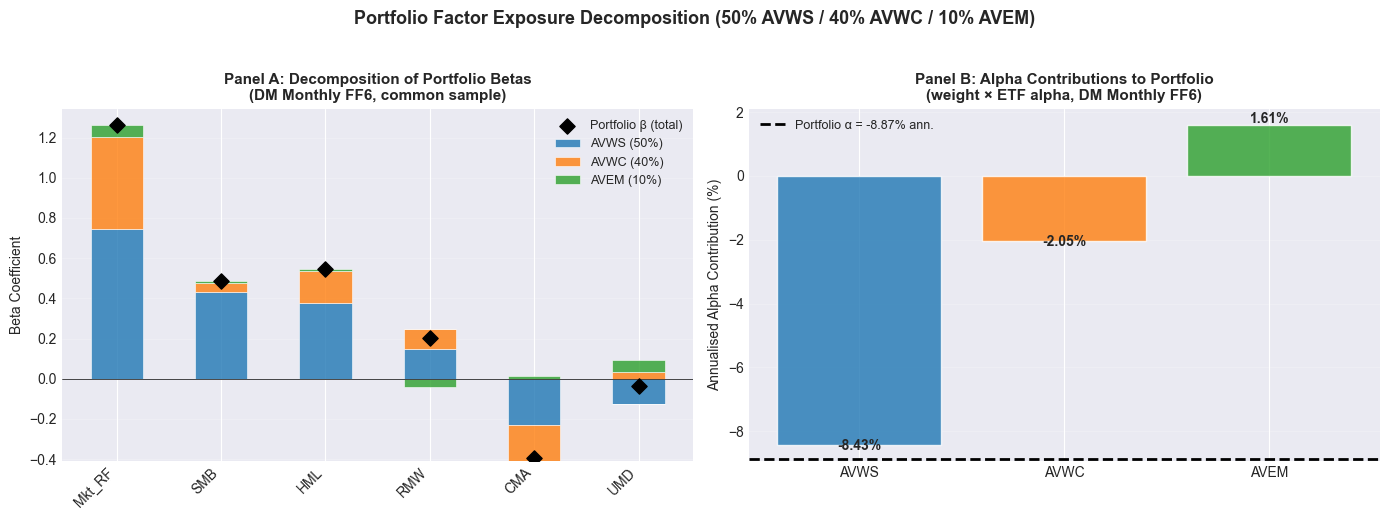

In [28]:
# ============================================================================
# 7.3 — Portfolio Factor Exposure Decomposition (Monthly, DM Factors)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

factor_labels = ff6_cols  # ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
etf_list = list(etf_tickers.keys())
etf_short = [t.replace('.DE', '') for t in etf_list]
colours = {'AVWS.DE': '#1f77b4', 'AVWC.DE': '#ff7f0e', 'AVEM.DE': '#2ca02c'}

# Panel A: Stacked contribution to portfolio betas
contributions = {}
for factor in factor_labels:
    j = ff6_cols.index(factor) + 1  # +1 to skip constant
    contributions[factor] = [weight_map[t] * etf_results_common[t].params[j]
                             for t in etf_list]

x = np.arange(len(factor_labels))
width = 0.5

# Stacked bars (handle positive and negative separately)
bottom_pos = np.zeros(len(factor_labels))
bottom_neg = np.zeros(len(factor_labels))

for i, ticker in enumerate(etf_list):
    short = ticker.replace('.DE', '')
    vals = np.array([contributions[f][i] for f in factor_labels])
    pos_vals = np.where(vals >= 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    axes[0].bar(x, pos_vals, width, bottom=bottom_pos, 
                label=f'{short} ({weight_map[ticker]:.0%})',
                color=colours[ticker], alpha=0.8, edgecolor='white', linewidth=0.5)
    axes[0].bar(x, neg_vals, width, bottom=bottom_neg,
                color=colours[ticker], alpha=0.8, edgecolor='white', linewidth=0.5)
    bottom_pos += pos_vals
    bottom_neg += neg_vals

# Overlay the total portfolio beta as markers
port_betas = [res_port_6f.params[ff6_cols.index(f) + 1] for f in factor_labels]
axes[0].scatter(x, port_betas, color='black', zorder=5, s=60, marker='D',
                label='Portfolio β (total)')

axes[0].set_xticks(x)
axes[0].set_xticklabels(factor_labels, rotation=45, ha='right')
axes[0].set_ylabel('Beta Coefficient')
axes[0].set_title('Panel A: Decomposition of Portfolio Betas\n(DM Monthly FF6, common sample)', 
                   fontweight='bold', fontsize=11)
axes[0].legend(loc='upper right', fontsize=9)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].grid(True, alpha=0.2, axis='y')

# Panel B: Alpha decomposition
alpha_contributions = [weight_map[t] * etf_results_common[t].params[0] * 12  # annualise
                       for t in etf_list]
port_alpha_ann = res_port_6f.params[0] * 12

bars = axes[1].bar(etf_short, alpha_contributions, 
                   color=[colours[t] for t in etf_list], alpha=0.8, edgecolor='white')
axes[1].axhline(port_alpha_ann, color='black', linewidth=2, linestyle='--',
                label=f'Portfolio α = {port_alpha_ann:.2f}% ann.')
axes[1].set_ylabel('Annualised Alpha Contribution (%)')
axes[1].set_title('Panel B: Alpha Contributions to Portfolio\n(weight × ETF alpha, DM Monthly FF6)', 
                   fontweight='bold', fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.2, axis='y')

# Add value labels
for bar, val in zip(bars, alpha_contributions):
    ypos = bar.get_height() + 0.05 if bar.get_height() >= 0 else bar.get_height() - 0.15
    axes[1].text(bar.get_x() + bar.get_width()/2, ypos, f'{val:.2f}%',
                 ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Portfolio Factor Exposure Decomposition (50% AVWS / 40% AVWC / 10% AVEM)',
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('avantis_portfolio_decomposition.png', dpi=100, bbox_inches='tight')
plt.show()

---

## Section 8: Limitations, Caveats, and Conclusions

### 8.1 Data Limitations

This analysis comes with important caveats that must inform interpretation:

**Short sample period.** With approximately 15–17 monthly observations for each ETF, we have limited statistical power. Monthly frequency is the correct choice for factor regressions (avoiding non-synchronous trading bias), but the short sample constrains precision:

- With ~15 monthly observations, the standard error of annualised alpha is very wide — even a "large" alpha of 3% p.a. could be statistically indistinguishable from zero
- The sample spans a single market regime — we cannot evaluate how these factor tilts perform through a full business cycle
- As emphasised throughout this series (Notebook 1, Section 3), **short samples amplify estimation error** and can produce misleading point estimates

**Why monthly, not daily?** These UCITS ETFs trade on Xetra, which closes several hours before the US market. Since Fama-French Developed Markets factors are weighted toward US stocks, daily factor returns reflect US close-to-close movements that occur *after* the ETF's last traded price. This **non-synchronous trading** systematically attenuates daily market betas (typically from ~1.0 monthly to ~0.65–0.85 daily). Monthly aggregation eliminates this microstructure artifact and produces betas that reflect genuine economic factor exposures.

**Factor universe matching.** We use **Developed Markets monthly factors (FF5 + Momentum)** for AVWS and AVWC, and **Emerging Markets monthly factors (FF5)** for AVEM:

- The DM and EM factor universes use different stock sorts — betas are not directly comparable across them
- We deliberately chose *not* to regress AVEM against developed-market factors, because this would be a model misspecification rather than merely a noisy proxy
- The portfolio-level regressions use DM factors, which is appropriate given the 90% DM weight

**Currency conversion.** Converting EUR-denominated ETF returns to USD uses the exact relationship $R^{USD} = (1 + R^{EUR})(1 + R^{FX}) - 1$, where $R^{FX}$ is the daily change in the EUR/USD exchange rate. This is methodologically correct for comparison with USD-denominated factors. The FX component adds noise that is orthogonal to factor returns, slightly inflating residual variance but not biasing beta estimates.

**Survivorship and incubation.** These ETFs are relatively new products. Their return histories do not reflect the long sample periods over which factor premia have been documented (typically 50+ years for US data, 30+ years for international).

### 8.2 What We *Can* Conclude

Despite these limitations, the monthly regressions allow us to draw **robust conclusions about factor exposure** (betas):

1. **AVWS delivers meaningful SMB and HML tilts** — This confirms that the fund's mandate (global small-cap value) is reflected in its actual holdings and returns, consistent with Avantis's "systematic and deliberate" approach
2. **AVWC provides broad market exposure with modest factor tilts** — Its market beta near 1.0 and smaller factor loadings make it suitable as a core holding
3. **AVEM's EM factor profile** — Despite the limited monthly sample, the EM regression reveals AVEM's factor tilts within its correct investment universe. Whether AVEM successfully targets value and profitability within EM will become clearer as more monthly data accumulates
4. **The portfolio achieves balanced factor exposure** — The 50/40/10 allocation delivers positive SMB and HML loadings against developed-market factors (appropriate given its 90% DM weight)

### 8.3 Connecting Back to the Series

This notebook applies concepts from every preceding chapter:

| Concept | Source | Application Here |
|:--------|:-------|:-----------------|
| OLS regression and hypothesis testing | Notebook 1, Sections 4–5 | Factor regressions on each ETF |
| Newey-West standard errors | Notebook 1, Section 6 | HAC-robust inference throughout |
| Time series stationarity | Notebook 2, Section 2 | Using returns (stationary) not prices |
| Autocorrelation diagnostics | Notebook 2, Sections 3–4 | Ljung-Box tests on residuals |
| Fama-French 3-Factor Model | Notebook 3, Sections 3–5 | FF3 regressions as baseline |
| FF5 and Momentum extensions | Notebook 4, Sections 2–3 | Full 5-/6-factor models |
| Non-synchronous trading | This notebook, Section 2 | Monthly aggregation to avoid bias |
| Residual diagnostics and model evaluation | Notebooks 3–4 | ACF, Q-Q, Jarque-Bera analysis |

### 8.4 Practical Takeaways

For the factor-aware investor:

1. **Factor investing is implementable** — Products like Avantis's UCITS ETFs allow investors to harvest factor premia without building custom portfolios. The expense ratios (0.25–0.36% p.a.) represent a significant reduction from the theoretical maximum premium.

2. **Diversification across factors and geographies matters** — No single factor dominates in all periods. A portfolio that targets multiple factors (value, size, profitability, momentum) through diversified vehicles is more robust than concentrated factor bets.

3. **Patience is required** — Factor premia are long-run phenomena. The data here covers a single short period. A proper evaluation requires 10+ years of data spanning multiple market environments, as discussed in Dai (2023) and the Dimensional research.

4. **Monitor but don't overreact** — As the sample grows, these analyses should be re-run. Short-term deviations from expected factor behaviour are *normal* — persistence of factor premia is measured in decades, not months.

> **Future work:** As these ETFs accumulate longer track records, this analysis should be extended with:
> - Rolling-window analysis to assess stability of factor exposures (once 60+ months are available)
> - Comparison with US-listed equivalents (e.g., AVUV, AVGV) that have longer histories
> - Conditional analysis across different market regimes (bull/bear, high/low volatility)
> - Inclusion of EM Momentum factor once the sample supports 6-factor EM regressions

---

## Section 9: Portfolio Holdings Analysis

The preceding sections analysed these ETFs through the lens of **return-based factor regressions** — a top-down approach that reveals how returns *co-move* with systematic factors. This section takes a complementary **bottom-up** approach, examining the actual holdings of each fund as reported by Avantis (as of 27 February 2026).

Holdings-level analysis answers different questions:

1. **Geographic allocation** — Where is the money invested? How does each fund's country/region mix compare?
2. **Concentration** — How diversified is each fund? Is weight concentrated in a few names, or spread broadly?
3. **Holdings overlap** — To what extent do AVWC, AVWS, and AVEM hold the same stocks? This matters for portfolio construction — overlap reduces the diversification benefit of combining funds.
4. **Security type** — How much does each fund use ADRs vs direct foreign listings?

### Data Source

Holdings data sourced directly from [Avantis UCITS ETF holdings pages](https://www.avantisinvestors.com/ucitsetf/). Country classification is derived from ISIN prefixes (ISO 3166-1 alpha-2), which reflect the country of **security registration** rather than the company's economic domicile. For example, many Chinese companies are registered in the Cayman Islands (KY) and will appear under that code.

In [31]:
# ── Section 9: Holdings Analysis ──────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ── 9.1  Load and parse holdings CSVs ────────────────────────────────────────
holdings = {}
for fn, etf in [('AVWC.csv', 'AVWC'), ('AVWS.csv', 'AVWS'), ('AVEM.csv', 'AVEM')]:
    df = pd.read_csv(fn, skiprows=7)
    # Drop metadata rows (SECURITY TYPE == '--')
    df = df[df['SECURITY TYPE'] != '--'].copy()
    # Parse weight from string "3.26%" → 0.0326
    df['weight'] = df['WEIGHT'].str.rstrip('%').astype(float) / 100
    df['mv'] = df['MARKET VALUE ($)']
    # Country from ISIN prefix (2-letter ISO code)
    df['country_code'] = df['ISIN'].str[:2]
    holdings[etf] = df

for etf, df in holdings.items():
    print(f"{etf}: {len(df):,} holdings, total MV = ${df['mv'].sum()/1e6:,.0f}M, "
          f"weight sum = {df['weight'].sum():.2%}")

# ── Country code → name / region mapping ─────────────────────────────────────
cc_to_name = {
    'US': 'United States', 'JP': 'Japan', 'CA': 'Canada', 'GB': 'United Kingdom',
    'CH': 'Switzerland', 'FR': 'France', 'DE': 'Germany', 'AU': 'Australia',
    'NL': 'Netherlands', 'SE': 'Sweden', 'IT': 'Italy', 'ES': 'Spain',
    'DK': 'Denmark', 'FI': 'Finland', 'NO': 'Norway', 'BE': 'Belgium',
    'AT': 'Austria', 'PT': 'Portugal', 'IE': 'Ireland', 'IL': 'Israel',
    'SG': 'Singapore', 'HK': 'Hong Kong', 'NZ': 'New Zealand',
    'TW': 'Taiwan', 'KR': 'South Korea', 'CN': 'China', 'IN': 'India',
    'BR': 'Brazil', 'ZA': 'South Africa', 'MX': 'Mexico', 'SA': 'Saudi Arabia',
    'TH': 'Thailand', 'ID': 'Indonesia', 'MY': 'Malaysia', 'PH': 'Philippines',
    'CL': 'Chile', 'CO': 'Colombia', 'PE': 'Peru', 'CZ': 'Czechia',
    'PL': 'Poland', 'HU': 'Hungary', 'GR': 'Greece', 'TR': 'Turkey',
    'KW': 'Kuwait', 'QA': 'Qatar', 'AE': 'UAE', 'EG': 'Egypt',
    'BM': 'Bermuda', 'KY': 'Cayman Islands', 'VG': 'BVI', 'JE': 'Jersey',
    'LU': 'Luxembourg', 'GG': 'Guernsey', 'IM': 'Isle of Man', 'PA': 'Panama',
    'PR': 'Puerto Rico', 'LR': 'Liberia',
}
cc_to_region = {
    'US': 'North America', 'CA': 'North America', 'BM': 'North America',
    'PR': 'North America', 'MX': 'Latin America', 'BR': 'Latin America',
    'CL': 'Latin America', 'CO': 'Latin America', 'PE': 'Latin America',
    'PA': 'Latin America', 'LR': 'North America',
    'GB': 'Europe', 'FR': 'Europe', 'DE': 'Europe', 'CH': 'Europe',
    'NL': 'Europe', 'SE': 'Europe', 'IT': 'Europe', 'ES': 'Europe',
    'DK': 'Europe', 'FI': 'Europe', 'NO': 'Europe', 'BE': 'Europe',
    'AT': 'Europe', 'PT': 'Europe', 'IE': 'Europe', 'LU': 'Europe',
    'JE': 'Europe', 'GG': 'Europe', 'IM': 'Europe', 'GR': 'Europe',
    'PL': 'Europe', 'CZ': 'Europe', 'HU': 'Europe', 'TR': 'Europe',
    'JP': 'Asia Pacific', 'AU': 'Asia Pacific', 'SG': 'Asia Pacific',
    'HK': 'Asia Pacific', 'NZ': 'Asia Pacific',
    'TW': 'Asia Pacific', 'KR': 'Asia Pacific',
    'CN': 'Asia Pacific', 'IN': 'Asia Pacific',
    'KY': 'Asia Pacific',   # Cayman-listed → mostly Chinese companies
    'VG': 'Asia Pacific',   # BVI-listed → mostly Chinese companies
    'TH': 'Asia Pacific', 'ID': 'Asia Pacific', 'MY': 'Asia Pacific',
    'PH': 'Asia Pacific',
    'ZA': 'Africa/Middle East', 'SA': 'Africa/Middle East',
    'KW': 'Africa/Middle East', 'QA': 'Africa/Middle East',
    'AE': 'Africa/Middle East', 'EG': 'Africa/Middle East',
    'IL': 'Africa/Middle East',
}

for etf in holdings:
    holdings[etf]['country'] = holdings[etf]['country_code'].map(cc_to_name).fillna(holdings[etf]['country_code'])
    holdings[etf]['region']  = holdings[etf]['country_code'].map(cc_to_region).fillna('Other')

print("\n✓ Holdings loaded and classified")

AVWC: 3,230 holdings, total MV = $486M, weight sum = 98.10%
AVWS: 1,329 holdings, total MV = $1,038M, weight sum = 99.36%
AVEM: 2,334 holdings, total MV = $155M, weight sum = 99.14%

✓ Holdings loaded and classified


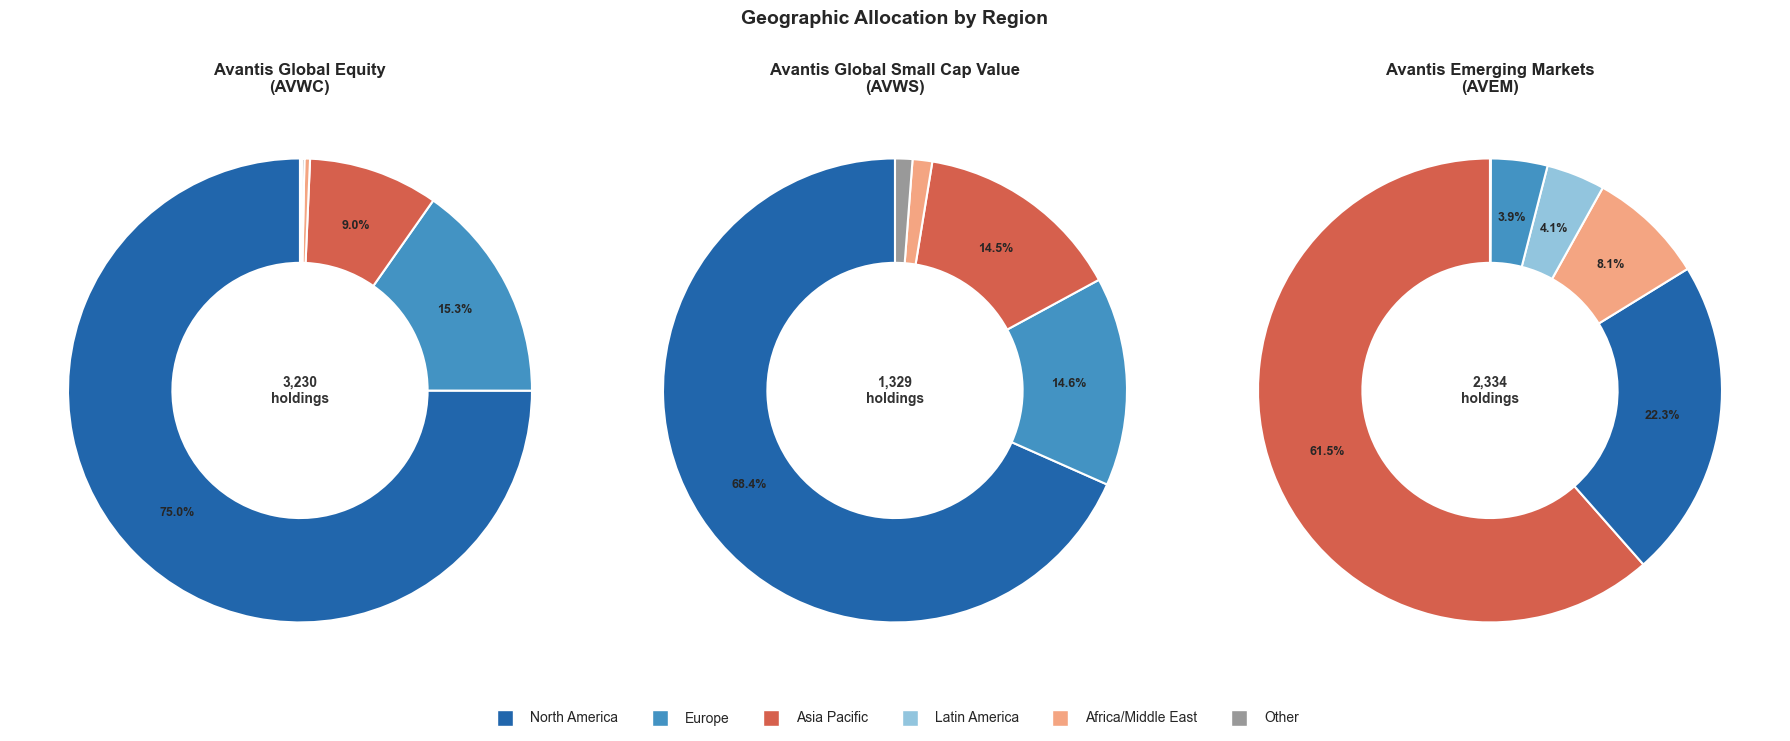


TOP 10 COUNTRIES BY WEIGHT
Country                   AVWC      AVWS      AVEM
--------------------------------------------------
United States            68.8%     59.9%     21.3%
Japan                     5.7%     10.1%         —
Taiwan                       —         —     14.0%
South Korea                  —         —     11.8%
Cayman Islands            0.3%      0.5%      9.8%
India                        —         —     10.5%
China                        —         —      8.0%
Canada                    3.8%      3.7%         —
United Kingdom            2.2%      4.1%      0.1%
Australia                 2.0%      3.1%         —
Bermuda                   0.6%      3.7%      0.8%
Switzerland               2.4%      1.6%         —
Germany                   2.2%      1.1%         —
France                    2.3%      0.9%         —
South Africa                 —         —      3.0%



In [32]:
# ── 9.2  Geographic Allocation ────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

etf_names = {'AVWC': 'Avantis Global Equity', 'AVWS': 'Avantis Global Small Cap Value',
             'AVEM': 'Avantis Emerging Markets'}
region_colours = {
    'North America': '#2166ac', 'Europe': '#4393c3', 'Asia Pacific': '#d6604d',
    'Latin America': '#92c5de', 'Africa/Middle East': '#f4a582', 'Other': '#999999'
}

for ax, etf in zip(axes, ['AVWC', 'AVWS', 'AVEM']):
    df = holdings[etf]
    
    # ── Region pie chart ──
    region_w = df.groupby('region')['weight'].sum().sort_values(ascending=False)
    colors = [region_colours.get(r, '#999999') for r in region_w.index]
    wedges, texts, autotexts = ax.pie(
        region_w.values, labels=None, autopct='%1.1f%%',
        colors=colors, startangle=90, pctdistance=0.75,
        wedgeprops=dict(width=0.45, edgecolor='white', linewidth=1.5)
    )
    for at in autotexts:
        at.set_fontsize(9)
        at.set_fontweight('bold')
    # Hide tiny slices' labels
    for at, val in zip(autotexts, region_w.values):
        if val < 0.03:
            at.set_text('')
    
    ax.set_title(f'{etf_names[etf]}\n({etf})', fontsize=12, fontweight='bold')
    n_holdings = len(df)
    total_mv = df['mv'].sum()
    ax.text(0, 0, f'{n_holdings:,}\nholdings',
            ha='center', va='center', fontsize=10, fontweight='bold', color='#333')

# Shared legend
handles = [plt.Line2D([0], [0], marker='s', color='w',
           markerfacecolor=region_colours[r], markersize=12, label=r)
           for r in region_colours if r in df.groupby('region')['weight'].sum().index
           or r in ['North America', 'Europe', 'Asia Pacific', 'Latin America', 'Africa/Middle East']]
fig.legend(handles=[plt.Line2D([0], [0], marker='s', color='w',
           markerfacecolor=c, markersize=12, label=r) for r, c in region_colours.items()],
           loc='lower center', ncol=6, fontsize=10, frameon=False,
           bbox_to_anchor=(0.5, -0.02))

fig.suptitle('Geographic Allocation by Region', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('holdings_geography.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Top country breakdown table ──
print("\n" + "="*80)
print("TOP 10 COUNTRIES BY WEIGHT")
print("="*80)
header = f"{'Country':<20}" + "".join(f"{'AVWC':>10}{'AVWS':>10}{'AVEM':>10}")
print(header)
print("-"*50)

# Collect all country weights
all_countries = set()
country_data = {}
for etf in ['AVWC', 'AVWS', 'AVEM']:
    cw = holdings[etf].groupby('country')['weight'].sum()
    country_data[etf] = cw
    all_countries.update(cw.index)

# Rank by combined weight
combined = pd.DataFrame(country_data).fillna(0)
combined['total'] = combined.sum(axis=1)
top15 = combined.sort_values('total', ascending=False).head(15)

for country in top15.index:
    vals = [f"{top15.loc[country, etf]:.1%}" if top15.loc[country, etf] > 0.001 else "   —" 
            for etf in ['AVWC', 'AVWS', 'AVEM']]
    print(f"{country:<20}" + "".join(f"{v:>10}" for v in vals))

print()

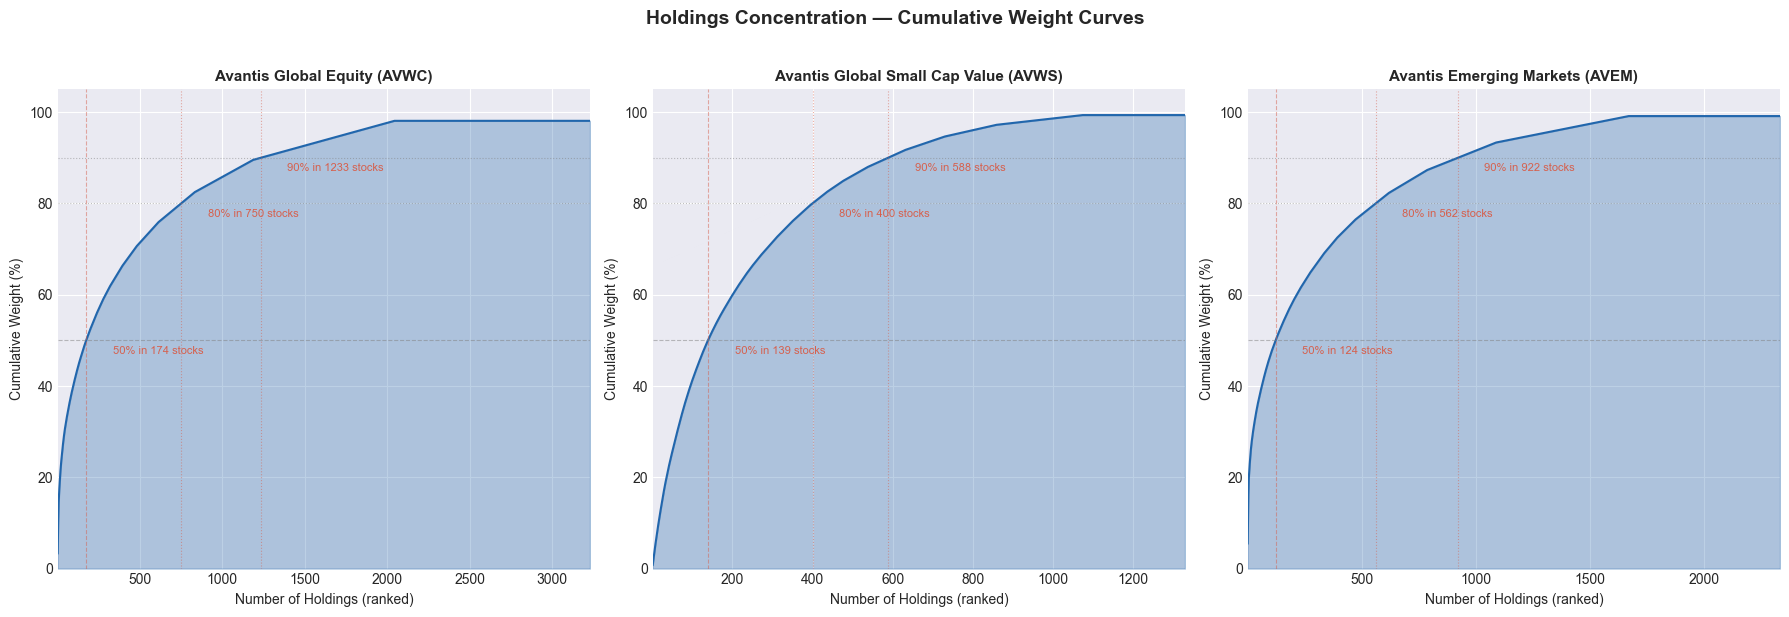


CONCENTRATION METRICS
Metric                                     AVWC        AVWS        AVEM
-----------------------------------------------------------------------
Total holdings                            3,230       1,329       2,334
Top holding weight                        3.26%       0.71%       5.42%
Top 10 weight                             16.8%        6.7%       23.0%
Top 50 weight                             31.8%       25.6%       37.2%
HHI (×10⁴)                                 45.9        25.1        89.2
Effective N (1/HHI)                         218         398         112
Stocks for 50% weight                       174         139         124
Stocks for 80% weight                       750         400         562

Note: HHI = Σwᵢ². A perfectly equal-weighted fund with N stocks has HHI = 1/N.
      Effective N = 1/HHI ≈ number of equal-weighted stocks that would give the same concentration.


In [33]:
# ── 9.3  Concentration Analysis ───────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, etf in zip(axes, ['AVWC', 'AVWS', 'AVEM']):
    df = holdings[etf].sort_values('weight', ascending=False).reset_index(drop=True)
    cumw = df['weight'].cumsum()
    n = len(df)
    
    ax.fill_between(range(1, n+1), cumw.values * 100, alpha=0.3, color='#2166ac')
    ax.plot(range(1, n+1), cumw.values * 100, color='#2166ac', linewidth=1.5)
    
    # Mark key thresholds
    for pct, ls in [(50, '--'), (80, ':'), (90, ':')]:
        try:
            idx = (cumw >= pct/100).idxmax() + 1
            ax.axhline(pct, color='grey', linestyle=ls, alpha=0.5, linewidth=0.8)
            ax.axvline(idx, color='#d6604d', linestyle=ls, alpha=0.5, linewidth=0.8)
            ax.annotate(f'{pct}% in {idx} stocks',
                       xy=(idx, pct), fontsize=8, color='#d6604d',
                       xytext=(idx + n*0.05, pct - 3))
        except Exception:
            pass
    
    ax.set_xlabel('Number of Holdings (ranked)', fontsize=10)
    ax.set_ylabel('Cumulative Weight (%)', fontsize=10)
    ax.set_title(f'{etf_names[etf]} ({etf})', fontsize=11, fontweight='bold')
    ax.set_ylim(0, 105)
    ax.set_xlim(1, n)

fig.suptitle('Holdings Concentration — Cumulative Weight Curves', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('holdings_concentration.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Concentration metrics table ──
print("\n" + "="*80)
print("CONCENTRATION METRICS")
print("="*80)
print(f"{'Metric':<35}{'AVWC':>12}{'AVWS':>12}{'AVEM':>12}")
print("-"*71)

for etf in ['AVWC', 'AVWS', 'AVEM']:
    df = holdings[etf]
    w = df['weight'].values
    pass  # We'll print row by row below

metrics = {}
for etf in ['AVWC', 'AVWS', 'AVEM']:
    df = holdings[etf].sort_values('weight', ascending=False)
    w = df['weight'].values
    cumw = np.cumsum(w)
    
    hhi = np.sum(w**2)                       # Herfindahl-Hirschman Index
    eff_n = 1 / hhi if hhi > 0 else 0        # Effective number of stocks
    top10_w = cumw[9] if len(w) >= 10 else cumw[-1]
    top50_w = cumw[49] if len(w) >= 50 else cumw[-1]
    max_w = w[0]
    # How many stocks for 50% of weight
    n50 = int((cumw >= 0.50).argmax()) + 1
    n80 = int((cumw >= 0.80).argmax()) + 1
    
    metrics[etf] = {
        'Total holdings': f"{len(df):,}",
        'Top holding weight': f"{max_w:.2%}",
        'Top 10 weight': f"{top10_w:.1%}",
        'Top 50 weight': f"{top50_w:.1%}",
        'HHI (×10⁴)': f"{hhi*1e4:.1f}",
        'Effective N (1/HHI)': f"{eff_n:.0f}",
        'Stocks for 50% weight': f"{n50}",
        'Stocks for 80% weight': f"{n80}",
    }

for metric in metrics['AVWC']:
    vals = [f"{metrics[etf][metric]:>12}" for etf in ['AVWC', 'AVWS', 'AVEM']]
    print(f"{metric:<35}" + "".join(vals))

print()
print("Note: HHI = Σwᵢ². A perfectly equal-weighted fund with N stocks has HHI = 1/N.")
print("      Effective N = 1/HHI ≈ number of equal-weighted stocks that would give the same concentration.")

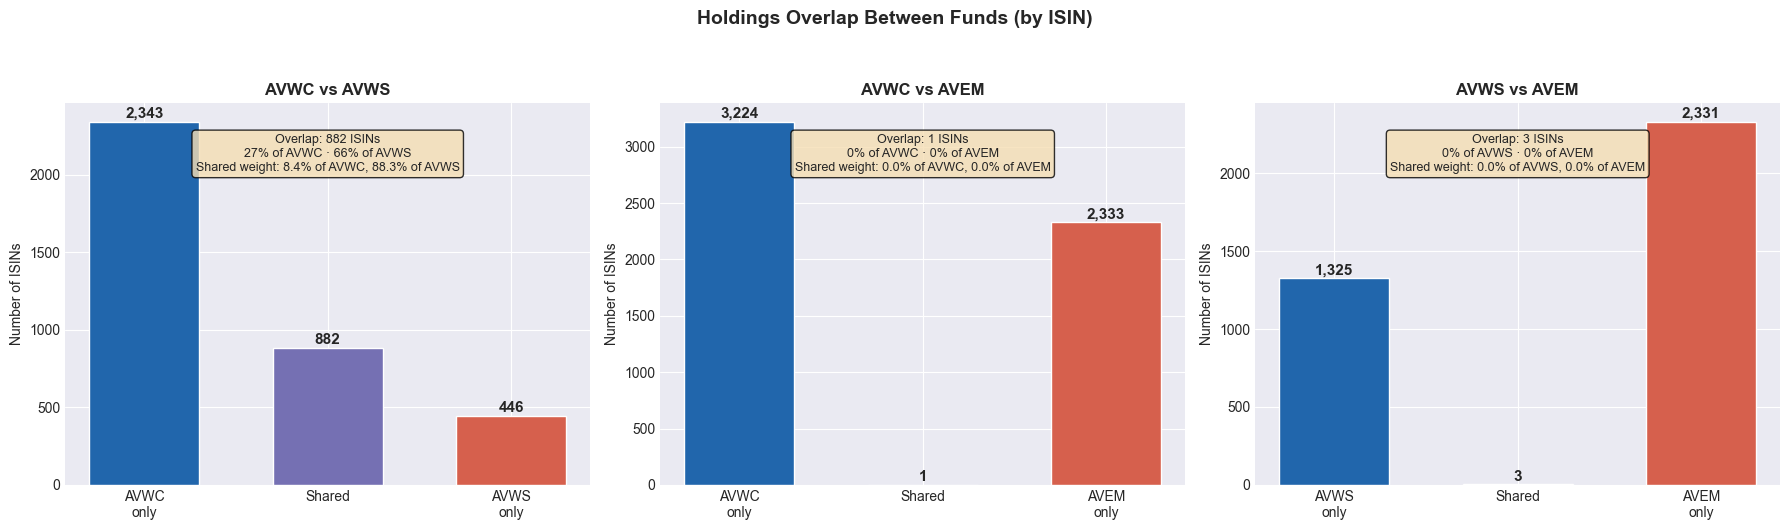


SECURITY TYPE BREAKDOWN (by weight)

Avantis Global Equity (AVWC):
  COMMON STOCK                                    68.4%
  FOREIGN COMMON STOCK                            25.4%
  FOREIGN ADR COMMON (DTC ELIGIBLE)                4.3%

Avantis Global Small Cap Value (AVWS):
  COMMON STOCK                                    68.3%
  FOREIGN COMMON STOCK                            31.0%

Avantis Emerging Markets (AVEM):
  FOREIGN COMMON STOCK                            76.9%
  FOREIGN ADR COMMON (DTC ELIGIBLE)               15.8%
  FOREIGN COMMON STOCK (USD)                       5.3%
  COMMON STOCK                                     1.1%

THREE-WAY OVERLAP: 0 ISINs appear in all three funds
  (No stocks appear in all three funds — expected given the distinct universes)



In [34]:
# ── 9.4  Holdings Overlap Analysis ────────────────────────────────────────────
# Use ISIN as the identifier — it's the most reliable cross-listing key.
# Note: the same company may appear via ADR (US ISIN) in one fund and local
#       listing (foreign ISIN) in another — these won't overlap on ISIN.
#       That's correct: they are *different securities*.

isins = {}
weights_by_isin = {}
for etf in ['AVWC', 'AVWS', 'AVEM']:
    df = holdings[etf]
    isins[etf] = set(df['ISIN'].dropna())
    weights_by_isin[etf] = df.set_index('ISIN')['weight'].to_dict()

pairs = [('AVWC', 'AVWS'), ('AVWC', 'AVEM'), ('AVWS', 'AVEM')]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (a, b) in zip(axes, pairs):
    shared = isins[a] & isins[b]
    only_a = isins[a] - isins[b]
    only_b = isins[b] - isins[a]
    
    # Weight of shared holdings in each fund
    w_shared_a = sum(weights_by_isin[a].get(i, 0) for i in shared)
    w_shared_b = sum(weights_by_isin[b].get(i, 0) for i in shared)
    
    # Venn-style bar chart
    cats = [f'{a}\nonly', 'Shared', f'{b}\nonly']
    counts = [len(only_a), len(shared), len(only_b)]
    colours = ['#2166ac', '#7570b3', '#d6604d']
    bars = ax.bar(cats, counts, color=colours, edgecolor='white', width=0.6)
    
    for bar_obj, c in zip(bars, counts):
        ax.text(bar_obj.get_x() + bar_obj.get_width()/2, bar_obj.get_height() + 5,
                f'{c:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_title(f'{a} vs {b}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of ISINs', fontsize=10)
    
    # Annotate overlap percentages
    pct_a = len(shared) / len(isins[a]) * 100
    pct_b = len(shared) / len(isins[b]) * 100
    ax.text(0.5, 0.92, f'Overlap: {len(shared)} ISINs\n'
            f'{pct_a:.0f}% of {a} · {pct_b:.0f}% of {b}\n'
            f'Shared weight: {w_shared_a:.1%} of {a}, {w_shared_b:.1%} of {b}',
            transform=ax.transAxes, ha='center', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

fig.suptitle('Holdings Overlap Between Funds (by ISIN)', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('holdings_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Security type breakdown ──
print("\n" + "="*80)
print("SECURITY TYPE BREAKDOWN (by weight)")
print("="*80)
for etf in ['AVWC', 'AVWS', 'AVEM']:
    print(f"\n{etf_names[etf]} ({etf}):")
    st = holdings[etf].groupby('SECURITY TYPE')['weight'].sum().sort_values(ascending=False)
    for stype, w in st.items():
        if w > 0.001:
            print(f"  {stype:<45} {w:>7.1%}")

# ── Three-way overlap ──
all_shared = isins['AVWC'] & isins['AVWS'] & isins['AVEM']
print(f"\n{'='*80}")
print(f"THREE-WAY OVERLAP: {len(all_shared)} ISINs appear in all three funds")
if len(all_shared) > 0:
    # Show the largest by combined weight
    overlap_rows = []
    for isin in all_shared:
        w_total = sum(weights_by_isin[e].get(isin, 0) for e in ['AVWC', 'AVWS', 'AVEM'])
        # Get company name
        for e in ['AVWC', 'AVWS', 'AVEM']:
            row = holdings[e][holdings[e]['ISIN'] == isin]
            if len(row) > 0:
                name = row.iloc[0]['COMPANY'][:40]
                ticker = row.iloc[0]['TICKER']
                break
        overlap_rows.append((name, ticker, isin,
                            weights_by_isin['AVWC'].get(isin, 0),
                            weights_by_isin['AVWS'].get(isin, 0),
                            weights_by_isin['AVEM'].get(isin, 0),
                            w_total))
    overlap_rows.sort(key=lambda x: -x[6])
    
    print(f"\n{'Company':<35}{'Ticker':<8}{'AVWC':>8}{'AVWS':>8}{'AVEM':>8}")
    print("-"*67)
    for name, tkr, isin, w1, w2, w3, wt in overlap_rows[:15]:
        print(f"{name:<35}{tkr:<8}{w1:>7.2%}{w2:>7.2%}{w3:>7.2%}")
else:
    print("  (No stocks appear in all three funds — expected given the distinct universes)")

print()

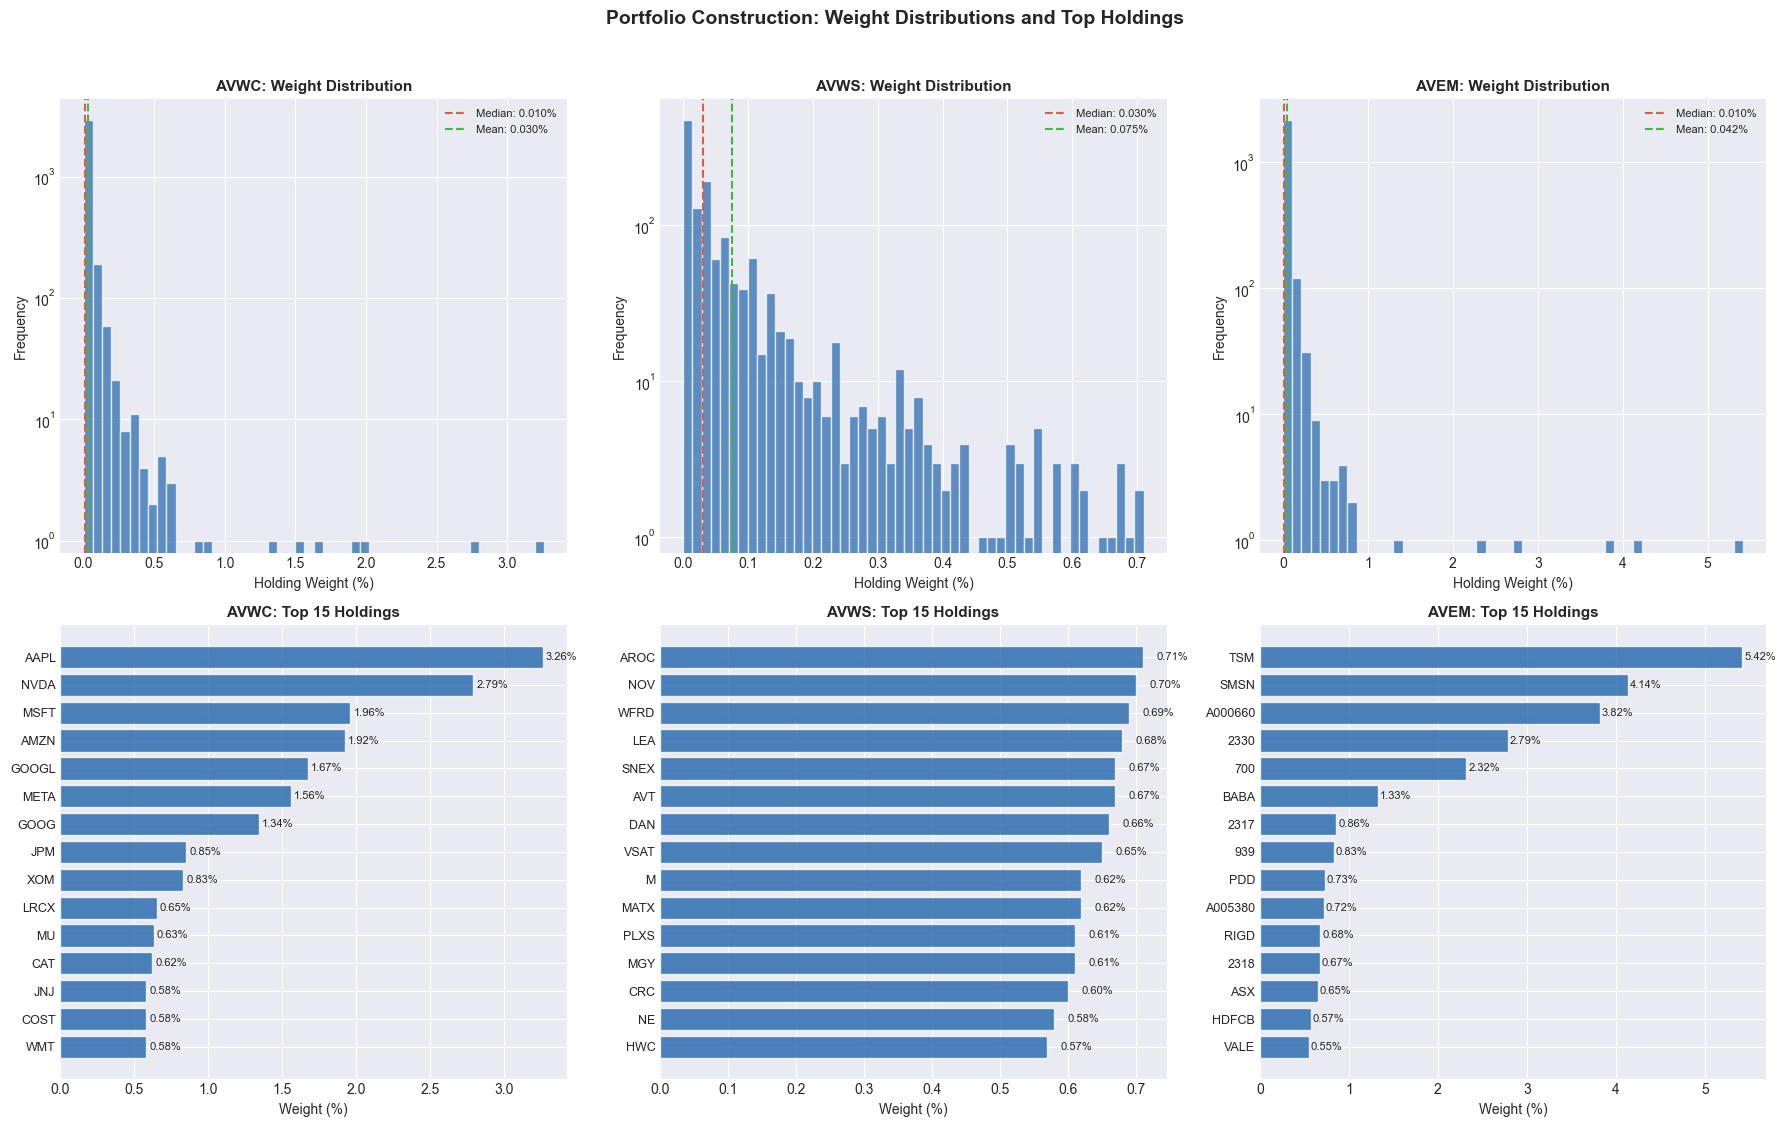


WEIGHT DISTRIBUTION STATISTICS
Statistic                        AVWC        AVWS        AVEM
-------------------------------------------------------------
Max weight                      3.26%       0.71%       5.42%
Mean weight                   0.0304%     0.0748%     0.0425%
Median weight                 0.0100%     0.0300%     0.0100%
Std dev weight                0.1152%     0.1153%     0.1909%
Skewness                         16.7         2.8        19.5
Equal-weight ref              0.0310%     0.0752%     0.0428%
Max / Equal ratio                105×          9×        127×

Interpretation:
• AVWC's right-skewed distribution reflects cap-weighted construction (AAPL = 3.3% vs median ~0.01%)
• AVWS is much more equal-weighted — consistent with small-cap value having a flatter weight curve
• AVEM shows moderate concentration in top EM names (TSM = 5.4%) with a long tail of smaller positions


In [35]:
# ── 9.5  Weight Distribution & Top Holdings ──────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

# ── Row 1: Weight distribution histograms ──
for ax, etf in zip(axes[0], ['AVWC', 'AVWS', 'AVEM']):
    w = holdings[etf]['weight'].values * 100  # in percent
    ax.hist(w, bins=50, color='#2166ac', alpha=0.7, edgecolor='white')
    ax.set_xlabel('Holding Weight (%)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{etf}: Weight Distribution', fontsize=11, fontweight='bold')
    ax.axvline(np.median(w), color='#d6604d', linestyle='--', linewidth=1.5,
               label=f'Median: {np.median(w):.3f}%')
    ax.axvline(np.mean(w), color='#4daf4a', linestyle='--', linewidth=1.5,
               label=f'Mean: {np.mean(w):.3f}%')
    ax.legend(fontsize=8, loc='upper right')
    # Log scale for y to show the long tail
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.8)

# ── Row 2: Top 15 holdings horizontal bar charts ──
for ax, etf in zip(axes[1], ['AVWC', 'AVWS', 'AVEM']):
    df = holdings[etf].sort_values('weight', ascending=False).head(15)
    companies = [c[:25] for c in df['TICKER'].values]  # Use ticker for brevity
    weights_pct = df['weight'].values * 100
    
    y_pos = np.arange(len(companies))
    bars = ax.barh(y_pos, weights_pct, color='#2166ac', alpha=0.8, edgecolor='white')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(companies, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Weight (%)', fontsize=10)
    ax.set_title(f'{etf}: Top 15 Holdings', fontsize=11, fontweight='bold')
    
    # Annotate bars
    for bar_obj, w_val in zip(bars, weights_pct):
        ax.text(bar_obj.get_width() + 0.02, bar_obj.get_y() + bar_obj.get_height()/2,
                f'{w_val:.2f}%', ha='left', va='center', fontsize=8)

fig.suptitle('Portfolio Construction: Weight Distributions and Top Holdings',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('holdings_weights.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Summary statistics ──
print("\n" + "="*80)
print("WEIGHT DISTRIBUTION STATISTICS")
print("="*80)
print(f"{'Statistic':<25}{'AVWC':>12}{'AVWS':>12}{'AVEM':>12}")
print("-"*61)
for stat_name, stat_fn in [
    ('Max weight', lambda w: f"{w.max():.2%}"),
    ('Mean weight', lambda w: f"{w.mean():.4%}"),
    ('Median weight', lambda w: f"{np.median(w):.4%}"),
    ('Std dev weight', lambda w: f"{w.std():.4%}"),
    ('Skewness', lambda w: f"{pd.Series(w).skew():.1f}"),
    ('Equal-weight ref', lambda w: f"{1/len(w):.4%}"),
    ('Max / Equal ratio', lambda w: f"{w.max() / (1/len(w)):.0f}×"),
]:
    vals = [f"{stat_fn(holdings[etf]['weight'].values):>12}" for etf in ['AVWC', 'AVWS', 'AVEM']]
    print(f"{stat_name:<25}" + "".join(vals))

print("\nInterpretation:")
print("• AVWC's right-skewed distribution reflects cap-weighted construction (AAPL = 3.3% vs median ~0.01%)")
print("• AVWS is much more equal-weighted — consistent with small-cap value having a flatter weight curve")
print("• AVEM shows moderate concentration in top EM names (TSM = 5.4%) with a long tail of smaller positions")